In [1]:
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%pylab inline

import pysal as ps
import pandas as pd
import seaborn as sns
import geopandas as gpd
import mgwr
import scipy
import statsmodels.api as sm

from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from scipy.stats import skew 
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from itertools import combinations as comb
from scipy import stats

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from collections import Counter

from matplotlib.lines import Line2D

from sklearn import preprocessing
from sklearn.linear_model import LassoLarsIC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

from itertools import combinations
from shapely.geometry import Point

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from pysal.viz.splot.libpysal import plot_spatial_weights


#from libpysal import plot_spatial_weights

generator = StratifiedKFold(5,shuffle=True) # 5 fold cv
scale = preprocessing.StandardScaler().fit_transform

Populating the interactive namespace from numpy and matplotlib


In [2]:
def setFont(ax, font, size):
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname(font)
        label.set_fontsize(size)
    return ax

======== **Table of contents** ========
* [1. Preprocessing](#preprocessing)
* [2. Spatial Analysis](#spatialanalysis)
* [3. Models](#models)
* [4. Feature Selection](#featureselection)
* [5. Increasing Complexity](#increasingc)
* [6. Cross Validation](#crossval)
* [7. Case Study - Public Transport](#casestudy)
* [8. Answer to reviewers](#answers)


<a id="preprocessing"></a> 
# 1. Preprocessing

<a id="1.1"></a>
## 1.1 Target Variables
Here we load the census data, and exctract the target variables

 **Selected Variables:**
 * p1: Fraction of foreigners
 * p2: Fraction of beneficiaries of the social assistance
 * t1: Cars per 1000 inhabitants
 * t2: Fraction of commuters using public transportation
 * w1 : Unemployment rate
 * w2: Unemployment rate between women
 * s1: Building area (%)
 * s2: Green area (%)
 * h1 : Vacancy rate (%)
 * h2: Average area per inhabitant in square meters
 * e1 : Municipal debt
 * e2: Fraction of investment in culture

In [3]:
swissData = pd.read_csv('../Data/swissData.csv') ## 90 variables + BFS Code that identifies the municipalities

tv =  ['pop23', 'pop29', 
       'trpt8','trpt10', 
       'trv11', 'trv2', 
       'esp2', 'esp3',
       'log2', 'log3', 
       'fin4', 'fin7']

nameVariables = ['p1','p2',
                 't1','t2',
                 'w1','w2',
                 's1','s2',
                 'h1','h2',
                 'e1','e2']

VarDescription=nameVariables

clrs = ['darkred', 'darkred',
        'darkgreen', 'darkgreen',
        'teal', 'teal',
         'y','y',
         'dimgray','dimgray',
         'sienna', 'sienna']
sd = swissData.filter(tv, axis=1)
sd.columns = nameVariables

sd['t2'] = sd['t2'] / swissData['trpt9'] ## Divide by the total number of commuters
sd['w2'] = sd['w2'] / swissData['pop3']  ## Divide by the number of women
sd['s1'] = sd['s1'] / swissData['esp1']  ## Divide by the total Area
sd['s2'] = sd['s2'] / swissData['esp1']  ## Divide by the total Area
sd['e1'] = sd['e1'] / swissData['fin1']  ## Divide by the total Revenue
sd['e2'] = sd['e2'] / swissData['fin5']  ## Divide by the total Investment
sd['pop1'] = swissData['pop1']
sd['BFS'] = swissData['BFS']

In [4]:
target_variables={
"p1": "Fraction of foreigners",
"p2": "Fraction of beneficiaries of the social assistance",
"t1": "Cars per 1000 inhabitants",
"t2": "Fraction of commuters using public transportation",
"w1": "Unemployment rate",
"w2": "Unemployment rate between women",
"s1": "Building area (%)",
"s2": "Green area (%)",
"h1": "Vacancy rate (%)",
"h2": "Average area per inhabitant in square meters",
"e1": "Municipal debt",
"e2": "Fraction of investment in culture"}

### Show Target Variables

In [5]:
sd.head()

p1        p2        t1        t2        w1        w2        s1  \
0  21.35862  3.549010  518.6347  0.386232  2.958045  0.013832  0.264182   
1  35.62053  3.106692  476.0431  0.451864  3.936226  0.018199  0.267696   
2  24.19482  1.317212  561.2726  0.363622  3.730497  0.016996  0.181081   
3  27.84874  3.442091  511.5966  0.372149  4.660264  0.018880  0.156752   
4  40.37747  8.278012  508.3827  0.327198  5.990914  0.021447  0.065814   

         s2        h1     h2        e1        e2   pop1   BFS  
0  0.055105  2.023799  47.85  0.019955  0.126747  21036  4001  
1  0.046332  0.856740  41.72  0.086333  0.042721  18742   131  
2  0.028378  0.989899  45.94  0.202755  0.126899  10184  2761  
3  0.017941  1.229070  44.27  0.121975  0.019021  11900     2  
4  0.034126  1.124285  38.20  0.084712  0.049193   9961  5401

<a id="1.1"></a>
## 1.2 Features
Here we load the **Insurance Data**, from which we will extract the features or predictors of the various models to predict insurance data

In [6]:
dfFeat = pd.read_csv('../data/featuresList2.csv')  ## Features of the paper
dfFeat = dfFeat.sort_values(by=['BFS']).reset_index(drop=True)

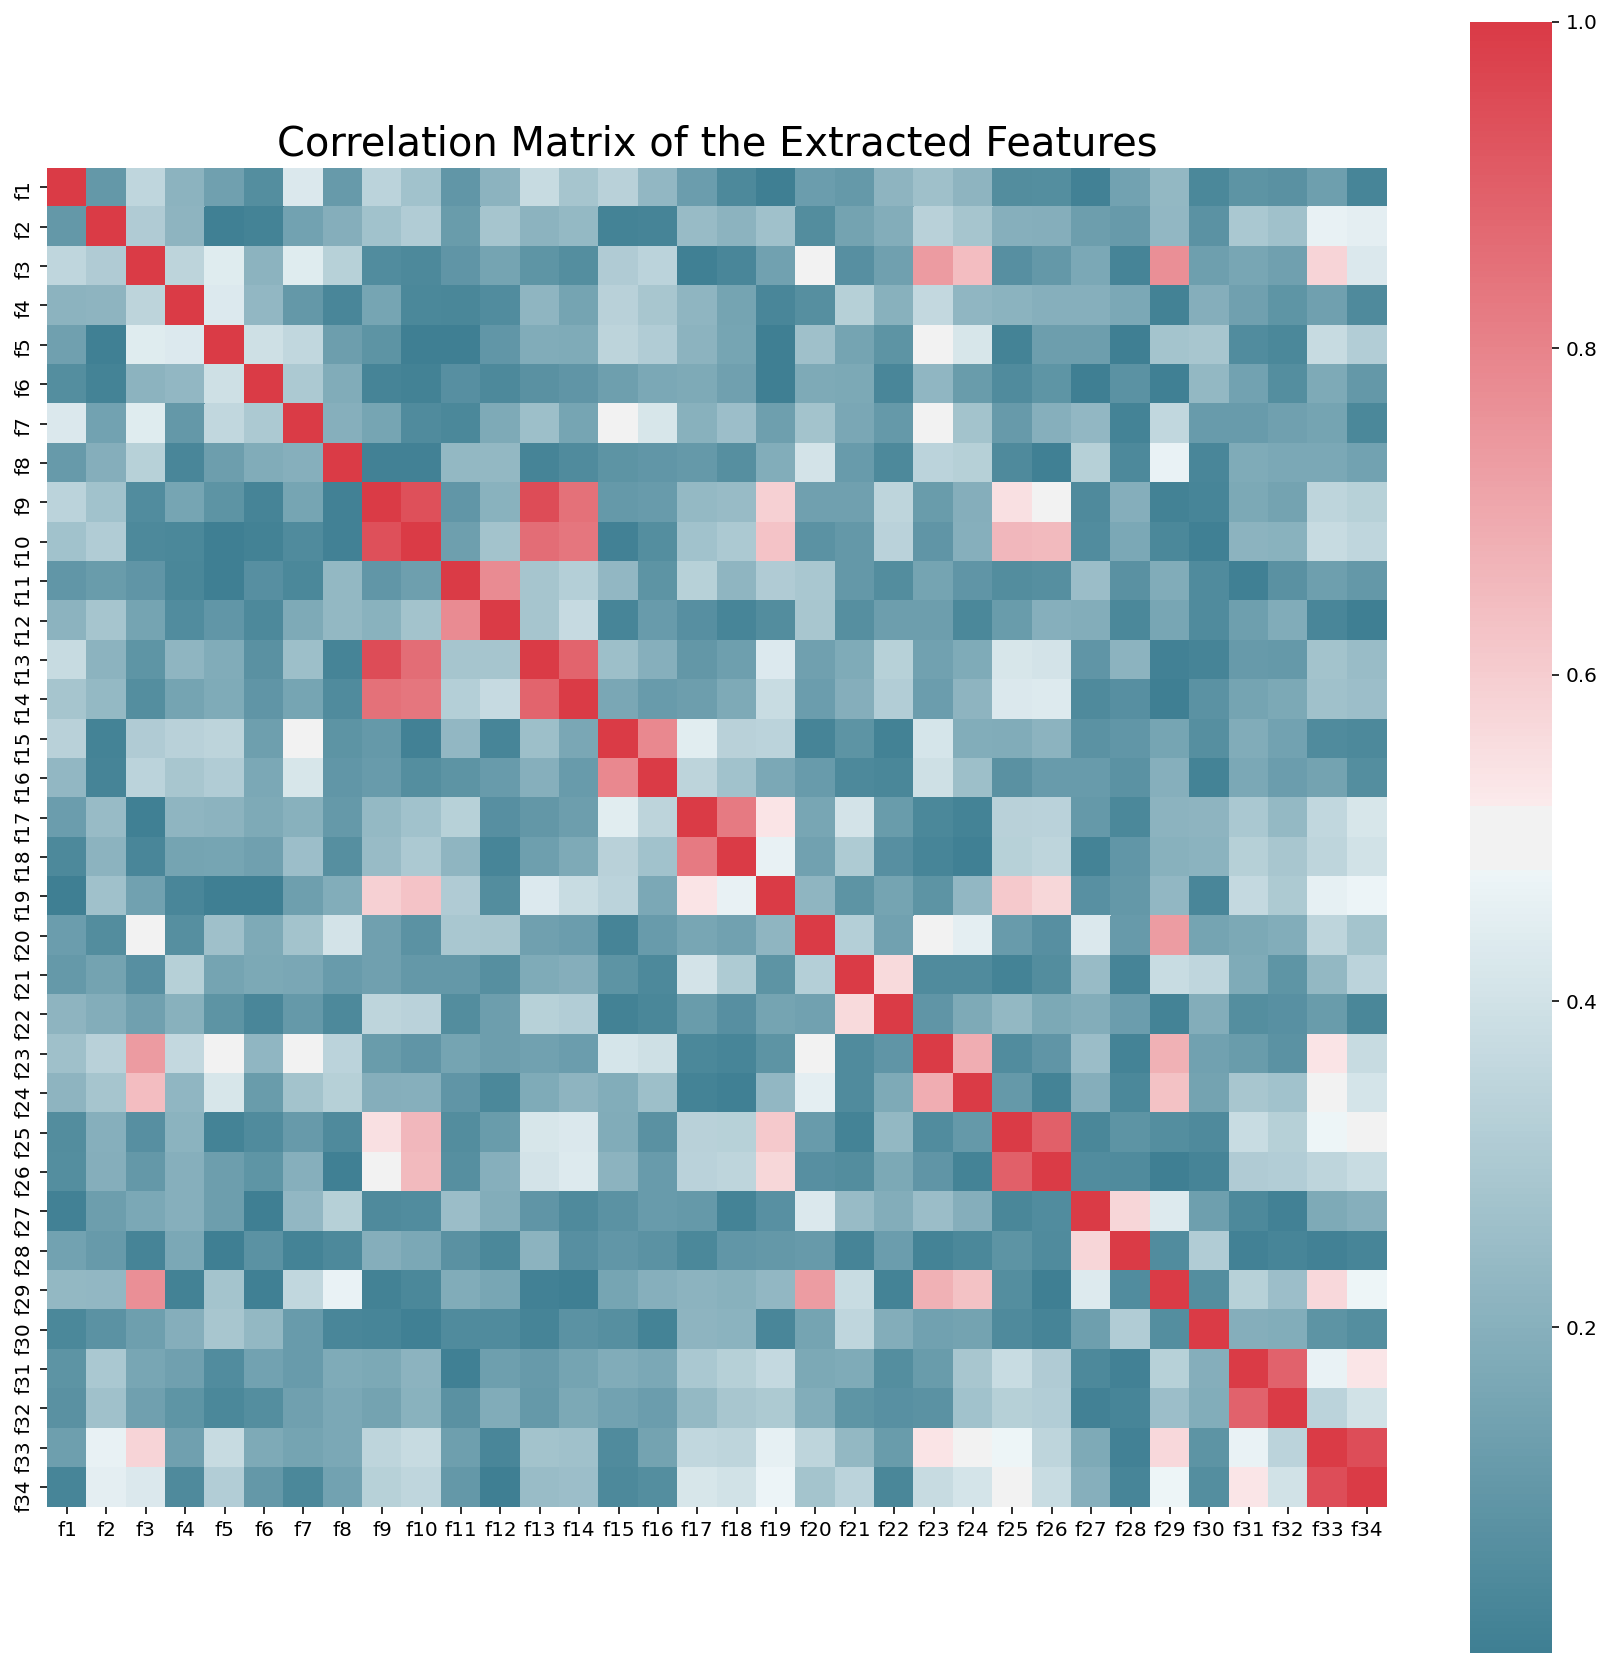

In [7]:
X = dfFeat.drop(['BFS'], axis=1)  ## remove municipality code
corr_matrix = X.corr().abs()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
ax.set_title('Correlation Matrix of the Extracted Features', size=20)
plt.show()

In [8]:
# Find features with correlation greater than 0.95 and we remove if any
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
dfFeat = dfFeat.drop(to_drop, axis=1) # drop the features

In [9]:
nunique = dfFeat.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
dfFeat = dfFeat.drop(cols_to_drop, axis=1)
dfFeat = dfFeat.astype(float)
dfFeatCol = dfFeat.columns  ## columns of the featueres
dfFeatCol = list(dfFeatCol.drop(['BFS']))

###  1.2.1 Features dictionary 
We define a dictionary that contains all the extracted features

In [10]:
features_dict={"f1" : "unemployment rate",
"f2" : "average age in the muncipality",
"f3" : "Fraction of owners (house)",
"f4" :  "Fraction of foreigners",
"f5" :  "Avg number of childer for customers with at least one children",
"f6" :  "Market Share",
"f7" :  "fraction of women",
"f8" :  "Number of customers divided by total customers",
"f9" :  "average price of the cars",
"f10" : "95th percentile price of the cars",
"f11" :  "Average Year of the car",
"f12" :  "5th percentile Year of the car",
"f13" :  "Average CCM of the car",
"f14" :  "95th percentile CCM of the car",
"f15" :  "Average number of claims per cars",
"f16" :  "95th percentile number of claims of the car",
"f17" :  "Average sum of claims of the car",
"f18" :  "95th percentile number of price of the car",
"f19" :  "Average sum of class premium of the car",
"f20" :  "Percent of insured cars",
"f21" :  "Average Class of Forniture",
"f22" :  "95th percentile  class of fornitures",
"f23" :  "Avg Number of Rooms",
"f24" :  "95th percentile  number of rooms",
"f25" :  "Average Building Insured Sum",
"f26" :  "95th Building Insured Sum",
"f27" :  "Average Building Year of Constructions",
"f28" :  "5th Percentile Building Year of Constructions",
"f29" :  "Average type of Building",
"f30" :  "Average number of claims per building",
"f31" :  "Average Sum of claims per building",
"f32" :  "95th Sum of claims per building",
"f33" :  "Average Insured Premium",
"f34" :  "95th Sum of Insured Premium"}

feature_names=list(features_dict.keys())

### 1.2.2 Population categories for Cross-Validation
We define a large dataframe that contains the features, the target variables, the coordinates, and all important information. Then we define the categories classes based on the population for the cross-validation

In [11]:
dfData = dfFeat.copy()
dfData = dfData.merge(sd, on ='BFS')
dfData['categories']=0
dfData.loc[dfData['pop1'] > 25000, 'categories'] = 1
dfData.loc[dfData['pop1'] > 80000, 'categories'] = 2

In [12]:
dfData

BFS        f1         f2        f3        f4        f5        f6  \
0       2.0  0.004076  52.423460  0.310688  0.181612  1.681193  0.185546   
1      52.0  0.000602  50.701564  0.360409  0.277377  1.727041  0.143079   
2      53.0  0.005682  50.868421  0.311304  0.272727  1.721501  0.170517   
3      62.0  0.002375  51.178939  0.189232  0.225653  1.602174  0.132348   
4      66.0  0.005456  45.585813  0.154266  0.319940  1.595870  0.308587   
..      ...       ...        ...       ...       ...       ...       ...   
165  6643.0  0.022965  54.284448  0.143030  0.364021  1.630542  0.141897   
166  6644.0  0.009719  52.914687  0.255940  0.335853  1.704036  0.069903   
167  6645.0  0.012486  55.009081  0.426788  0.251986  1.716279  0.076376   
168  6711.0  0.020294  53.145245  0.345802  0.205332  1.730000  0.200048   
169  6800.0  0.014224  54.158318  0.400124  0.159555  1.786111  0.235166   

           f7        f8           f9  ...        w1        w2        s1  \
0    0.417572  0.330555  35635.15017  ...  4.660264  0.018880  0.156752   
1    0.361613  0.248814  37944.82759  ...  3.287427  0.018064  0.155039   
2    0.374103  0.500623  36379.87520  ...  3.148378  0.015928  0.139838   
3    0.380443  0.379659  37895.78164  ...  4.602514  0.023342  0.118319   
4    0.378472  0.905433  37726.81282  ...  6.337074  0.028253  0.270125   
..        ...       ...          ...  ...       ...       ...       ...   
165  0.414988  0.743149  33638.80939  ...  6.143933  0.025310  0.327698   
166  0.447084  0.138629  34838.70968  ...  5.158093  0.021532  0.194286   
167  0.380250  0.131893  38958.21727  ...  4.010368  0.016447  0.346154   
168  0.434142  0.376216  31210.97046  ...  6.441658  0.026761  0.097861   
169  0.411255  0.242077  31502.00803  ...  6.105311  0.023339  0.107046   

           s2        h1     h2        e1        e2   pop1  categories  
0    0.017941  1.229070  44.27  0.121975  0.019021  11900           0  
1    0.026578  1.141862  43.99  0.105088  0.021741  11616           0  
2    0.018024  1.927867  44.17  0.135364  0.054686  19611           0  
3    0.022833  0.569889  40.51  0.123631  0.104128  19086           0  
4    0.064401  1.106934  37.81  0.199017  0.029575  19599           0  
..        ...       ...    ...       ...       ...    ...         ...  
165  0.062419  0.415829  31.49  0.163390  0.237122  34983           1  
166  0.027619  0.226159  36.66  0.162417  0.149072  13247           0  
167  0.063077  0.388633  41.34  0.197490  0.223310  11535           0  
168  0.010924  1.906069  44.24  0.106275  0.077155  12562           0  
169  0.014905  3.192298  49.63  0.121043  0.036957   6876           0  

[170 rows x 49 columns]

<a id="spatialanalysis"></a> 
# 2. Spatial Analysis
 * back to [Table of Contents](#toc)

#### 2.1 Load shaperfile of municipality and cantons

In [13]:
mun       = gpd.read_file('../data/shapeFiles/municipalities.shp')
mun       = mun.to_crs({'init': 'epsg:21781'})
mun.drop_duplicates(subset='BFS_NUMMER', keep="last",inplace=True)
mun_ = mun.filter(['BFS_NUMMER', 'geometry'])

cantons   = gpd.read_file("../data/shapeFiles/cantons.shp")
cantons   = cantons.to_crs({'init': 'epsg:21781'})

dfData = pd.merge(dfData, mun_, left_on ='BFS', right_on='BFS_NUMMER')

In [14]:
dfData = gpd.GeoDataFrame(dfData,geometry='geometry')
coord = pd.read_csv('../data/bfs_name_coordinates.csv',delimiter=',', encoding="iso-8859-1")
dfData = pd.merge(dfData, coord, on = 'BFS')
dfData['g_coords'] = list(zip(dfData['Xcoord'],dfData['Ycoord']))
g_coords = list(dfData.g_coords.values)

### 2.2 Create matrix weights for our analysis
from libpysal.weights import KNN, Kernel
w_knn = KNN.from_dataframe(dfData)
w_gaussian = Kernel.from_dataframe(dfData, function='gaussian')


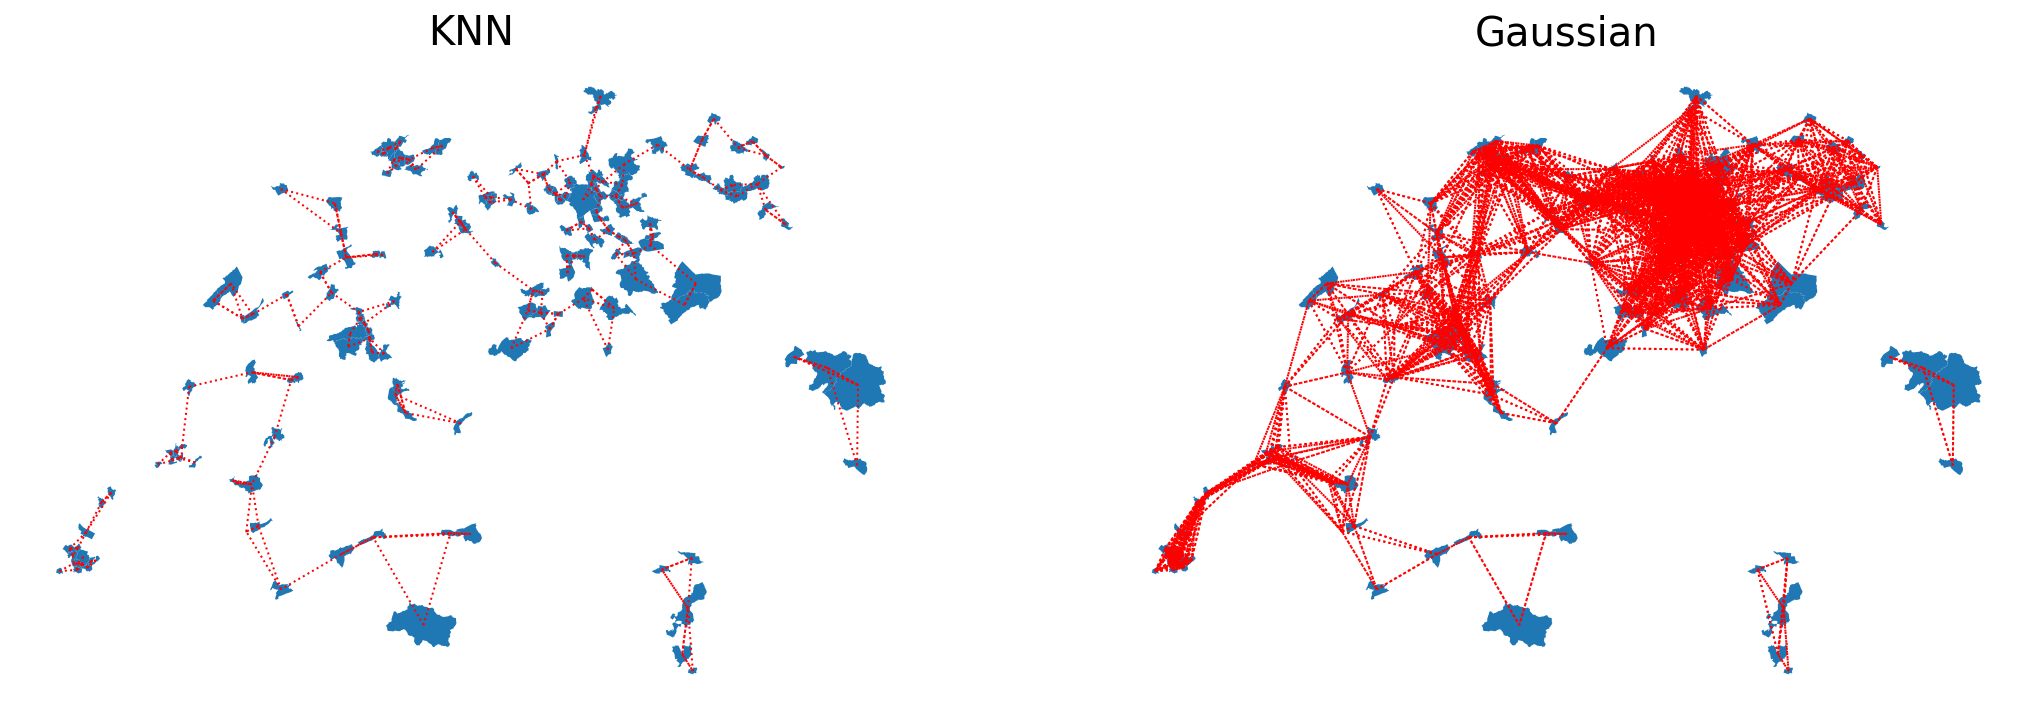

In [15]:
f, ax = plt.subplots(1,2,figsize=(18,6))
ax0 = ax[0]
ax0 = setFont(ax0, 'Arial', 18)
w_knn.plot(dfData, ax=ax0,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
dfData.plot(ax=ax0)
ax0.set_title('KNN', size=20)
ax0.axis('off');

ax1 = ax[1]
ax1 = setFont(ax1, 'Arial', 18)
w_gaussian.plot(dfData, ax=ax1,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
dfData.plot(ax=ax1)
ax1.set_title('Gaussian', size=20)
ax1.axis('off');

### 2.2 Compute Moran's I of the target variables

In [16]:
I = []
for k in target_variables:
    y = dfData[k]
    mi = ps.explore.esda.Moran(y, w_gaussian)
    I.append((k, round(mi.I,2)))

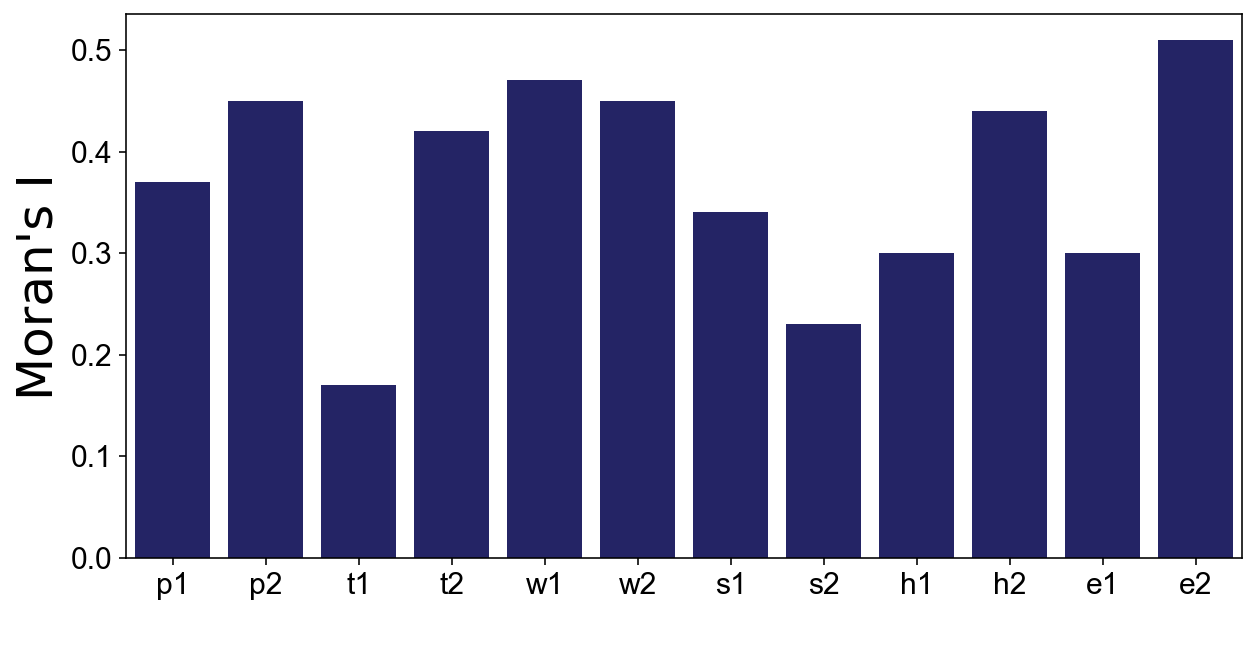

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(15)

g=sns.barplot([x[0] for x in I], [x[1] for x in I], color='midnightblue')
ax.set_ylabel("Moran's I",size = 25)
ax.set_xlabel(' ',size = 25);

<a id="featureselection"></a> 

# 3. Models
* back to [Table of Contents](#toc)

We introduce 3 different models:

* [OLS]: Stander Ordinary Least Square 
* [GWR]: Geographical Weighted Regression
* [SLM]: Spatial Lagged Model

In [18]:
def run_OLS(df,target_var, predictor_vars):    
    X,y = extract_scale_features(df,target_var,predictor_vars)
    estimator  = sm.OLS(y, sm.add_constant(X)).fit()
    return estimator

In [19]:
def run_GWR(df,target_var,predictor_vars):
    X,y = extract_scale_features(df,target_var,predictor_vars)
    g_coords = list(df.g_coords.values)
    gwr_bandwidth = Sel_BW(g_coords, y, X, kernel='gaussian', fixed=True).search(criterion='AICc')
    estimator = GWR(g_coords, y, X, gwr_bandwidth, kernel='gaussian', fixed=True).fit()
    return estimator

In [20]:
def generate_W_knn(df,p=2,k=5):
    kd = ps.lib.cg.kdtree.KDTree(df[['Xcoord','Ycoord']].values)
    return ps.lib.weights.KNN(kd, p=p, k=k)
W_knn = generate_W_knn(dfData)
def run_SLM(df,target_var, predictor_vars, W = W_knn): 
    X,y = extract_scale_features(df,target_var,predictor_vars)
    estimator = ps.model.spreg.GM_Lag(y, X, w=W, spat_diag=True)        
    return estimator

<a id="featureselection"></a> 

# 4. Feature Selection
* back to [Table of Contents](#toc)

In [21]:
def get_r2(est):
    try:
        return est.R2
    except:
        pass
    try:
        return est.rsquared
    except:
        pass
    try:
        return r2_score(est.y,est.predy)
    except:
        return np.nan

def extract_scale_features(df,target_var,predictor_vars):
    return scale(df[predictor_vars].values),scale(df[target_var].values.reshape(-1, 1))

def feature_selection(df,target_var,predictor_vars=feature_names):
    xNorm,yNorm = extract_scale_features(df,target_var,predictor_vars)

    model_bic = LassoLarsIC(criterion='bic',normalize=False)
    model_bic.fit(xNorm, ravel(yNorm))
    
    return [predictor_vars[i] for i in np.squeeze(np.nonzero(model_bic.coef_))]

### 4.0 Baseline Models
It uses the regression models defined aboove but with as input the census data variables

In [22]:
r2_baseline={}
selected_feats={}
for i,target in enumerate(target_variables):
    varnames = feature_selection(dfData,target)
    pred = [i for i in target_variables if target[0] not in i]
    ##run the different models with the selected variables
    est_ols = run_OLS(dfData,target,pred)
    est_gwr = run_GWR(dfData,target,pred)
    if target=='e1':
        est_slm = est_ols
    else:
        est_slm = run_SLM(dfData,target,pred,W_knn)
    r2_baseline[target] = [est_ols,est_gwr,est_slm]

### 4.1 Insurance Data Models

In [23]:
selected_feats={}
selected_models={}
g_coords = list(dfData.g_coords.values)
for i,target in enumerate(target_variables):
    varnames = feature_selection(dfData,target)
    selected_feats[target] = varnames
    ##run the different models with the selected variables
    est_ols = run_OLS(dfData,target,varnames)
    est_gwr = run_GWR(dfData,target,varnames)
    est_slm = run_SLM(dfData,target,varnames, W = W_knn)
    selected_models[target] = [est_ols,est_gwr,est_slm]

In [24]:
for i in selected_feats:
    print("--------------------\n")
    print("Variable = " + i)
    print("Features = " + str(selected_feats[i]))
    for feats in selected_feats[i]:
        print(features_dict[feats])

--------------------

Variable = p1
Features = ['f3', 'f4', 'f7', 'f23']
Fraction of owners (house)
Fraction of foreigners
fraction of women
Avg Number of Rooms
--------------------

Variable = p2
Features = ['f1', 'f9', 'f13', 'f15', 'f23']
unemployment rate
average price of the cars
Average CCM of the car
Average number of claims per cars
Avg Number of Rooms
--------------------

Variable = t1
Features = ['f1', 'f6', 'f7', 'f8', 'f17', 'f19', 'f20', 'f21', 'f23', 'f27']
unemployment rate
Market Share
fraction of women
Number of customers divided by total customers
Average sum of claims of the car
Average sum of class premium of the car
Percent of insured cars
Average Class of Forniture
Avg Number of Rooms
Average Building Year of Constructions
--------------------

Variable = t2
Features = ['f3', 'f6', 'f20', 'f22', 'f25']
Fraction of owners (house)
Market Share
Percent of insured cars
95th percentile  class of fornitures
Average Building Insured Sum
--------------------

Variable = 

In [25]:
import time
import stability as st

def get_current_time():
    return int(round(time.time()))

def run_feature_selection(X, y):
    
    model = LassoLarsIC(criterion='bic', normalize=False)
    model.fit(X, ravel(y))
    
    return np.nonzero(model.coef_)[0]

for ycol in target_variables:    
    
    features_set = []
    
    for niter in range(200):

        df_sample = dfData.sample(n=round(0.8*dfFeat.shape[0]))
            
        X = df_sample.filter(dfFeatCol, axis=1)  ## features
        xNorm = scale(X.values)
    
        y = df_sample[ycol]
        y = np.array(y).reshape(-1,1) 
        yNorm = scale(y)
        
        selected = run_feature_selection(xNorm, yNorm)
    
        values = list(np.zeros(len(dfFeatCol)))
        for idx in selected:
            values[idx] = 1
        features_set.append(values)
        
    Z = np.array(features_set)

    stability = st.getStability(Z)
    print("%s: %f" %(ycol, stability))
    

p1: 0.840149
p2: 0.680345
t1: 0.557939
t2: 0.776813
w1: 0.711053
w2: 0.715504
s1: 0.557185
s2: 0.607171
h1: 0.446805
h2: 0.722387
e1: 0.198976
e2: 0.658480


### 4.2 Standard Models Performance

In [26]:
cols = ['target_variable','model','r2']
df_r2=pd.DataFrame(columns=cols)
for i,j in zip(selected_models.keys(),selected_models.values()):
    for est, model in zip(j,['OLS','GWR','SLM']):
        df_r2=df_r2.append(pd.DataFrame(columns=cols,data=[[i,model,get_r2(est)]]),ignore_index=True)

(0.0, 1.0)

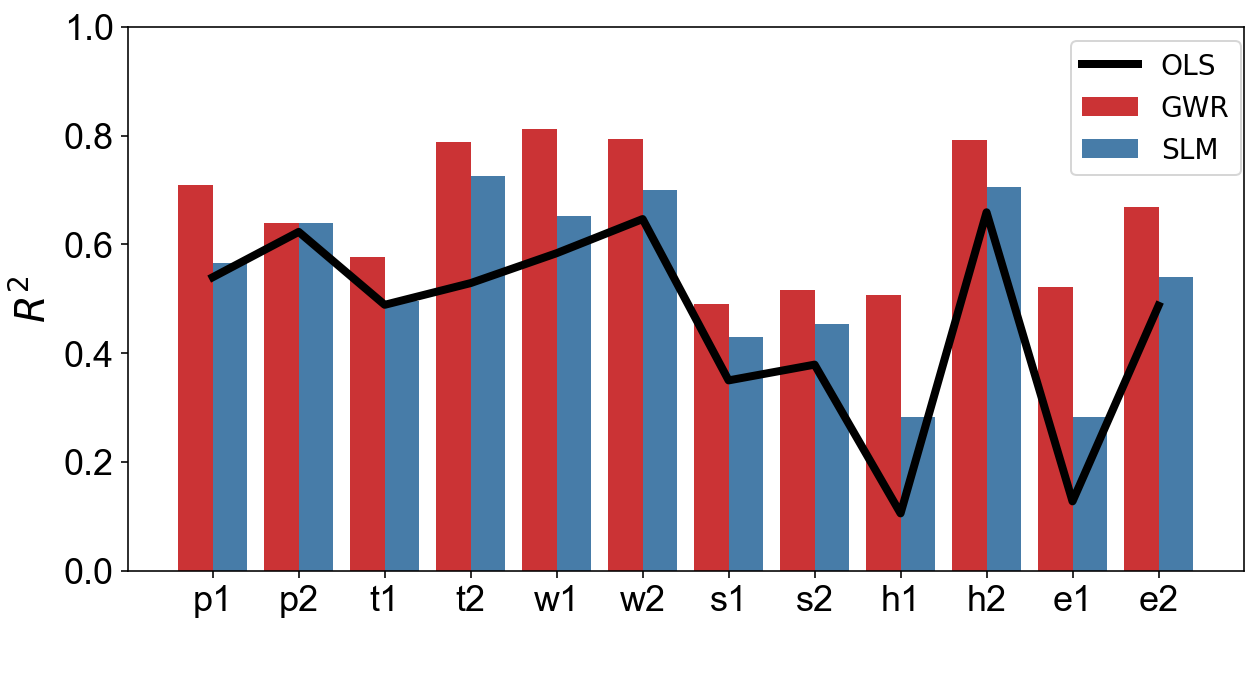

In [27]:
f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
tmp = df_r2[df_r2['model']!='OLS']
sns.barplot(data=tmp,hue='model',x='target_variable',y='r2', palette='Set1')
tmp = df_r2[df_r2['model']=='OLS']
ax.plot(tmp['target_variable'], tmp['r2'], color='black', lw=4, label='OLS')
ax.set_ylabel(r'$R^2$', size=20)
ax.set_xlabel(r' ', size=20)
ax.legend(fontsize=14, bbox_to_anchor=(1.01,1))
ax.set_ylim((0,1))
#ax.set_title('Full dataset', size=18)

In [28]:
#f.savefig('../PaperV1/figures/fig3UP.pdf',dpi=300,bbox_inches='tight')

### 4.3 Baseline Models Performance

In [29]:
cols = ['target_variable','model','r2']
df_r2_b=pd.DataFrame(columns=cols)
for i,j in zip(r2_baseline.keys(),r2_baseline.values()):
    for est, model in zip(j,['OLS','GWR','SLM']):
        df_r2_b=df_r2_b.append(pd.DataFrame(columns=cols,data=[[i,model,get_r2(est)]]),ignore_index=True)

Text(0.5, 1.0, 'Performance of the Baseline models')

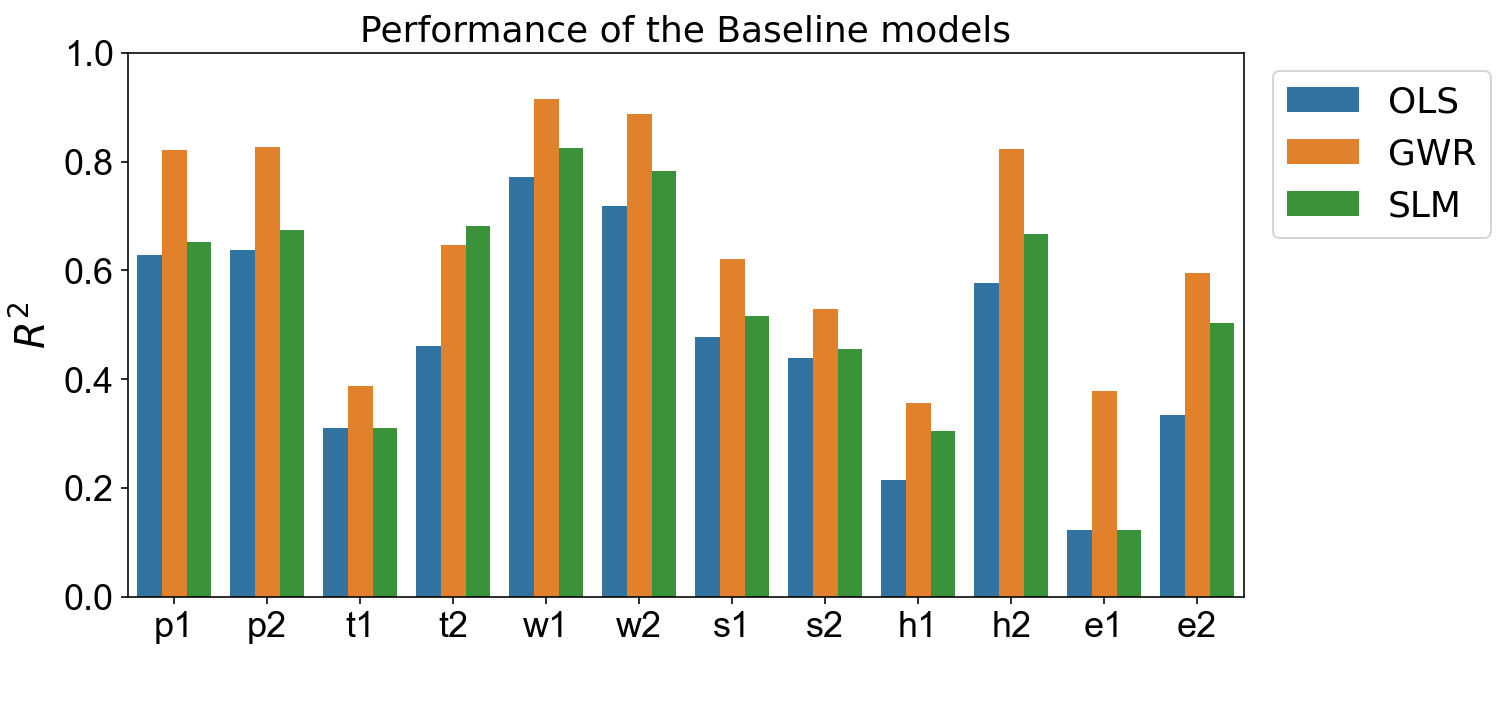

In [30]:
f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
sns.barplot(data=df_r2_b,hue='model',x='target_variable',y='r2')
ax.set_ylabel(r'$R^2$', size=20)
ax.set_xlabel(r' ', size=20)
ax.legend(fontsize=18, bbox_to_anchor=(1.01,1))
ax.set_ylim((0,1))
ax.set_title('Performance of the Baseline models', size=18)

In [31]:
f.savefig('../PaperV1/figures/fig3New.pdf',dpi=300,bbox_inches='tight')

### 4.4 Comparison between the baseline and the insurance models

In [32]:
def mergeBaselineResults(df_r2, df_r2_b, col):
    tmp = df_r2[df_r2['model']==col]
    del(tmp['model'])
    tmp.columns = ['target_variable', 'r2_ins']
    tmp_b = df_r2_b[df_r2_b['model']==col]
    tmp['r2_baseline']=tmp_b['r2']
    return tmp

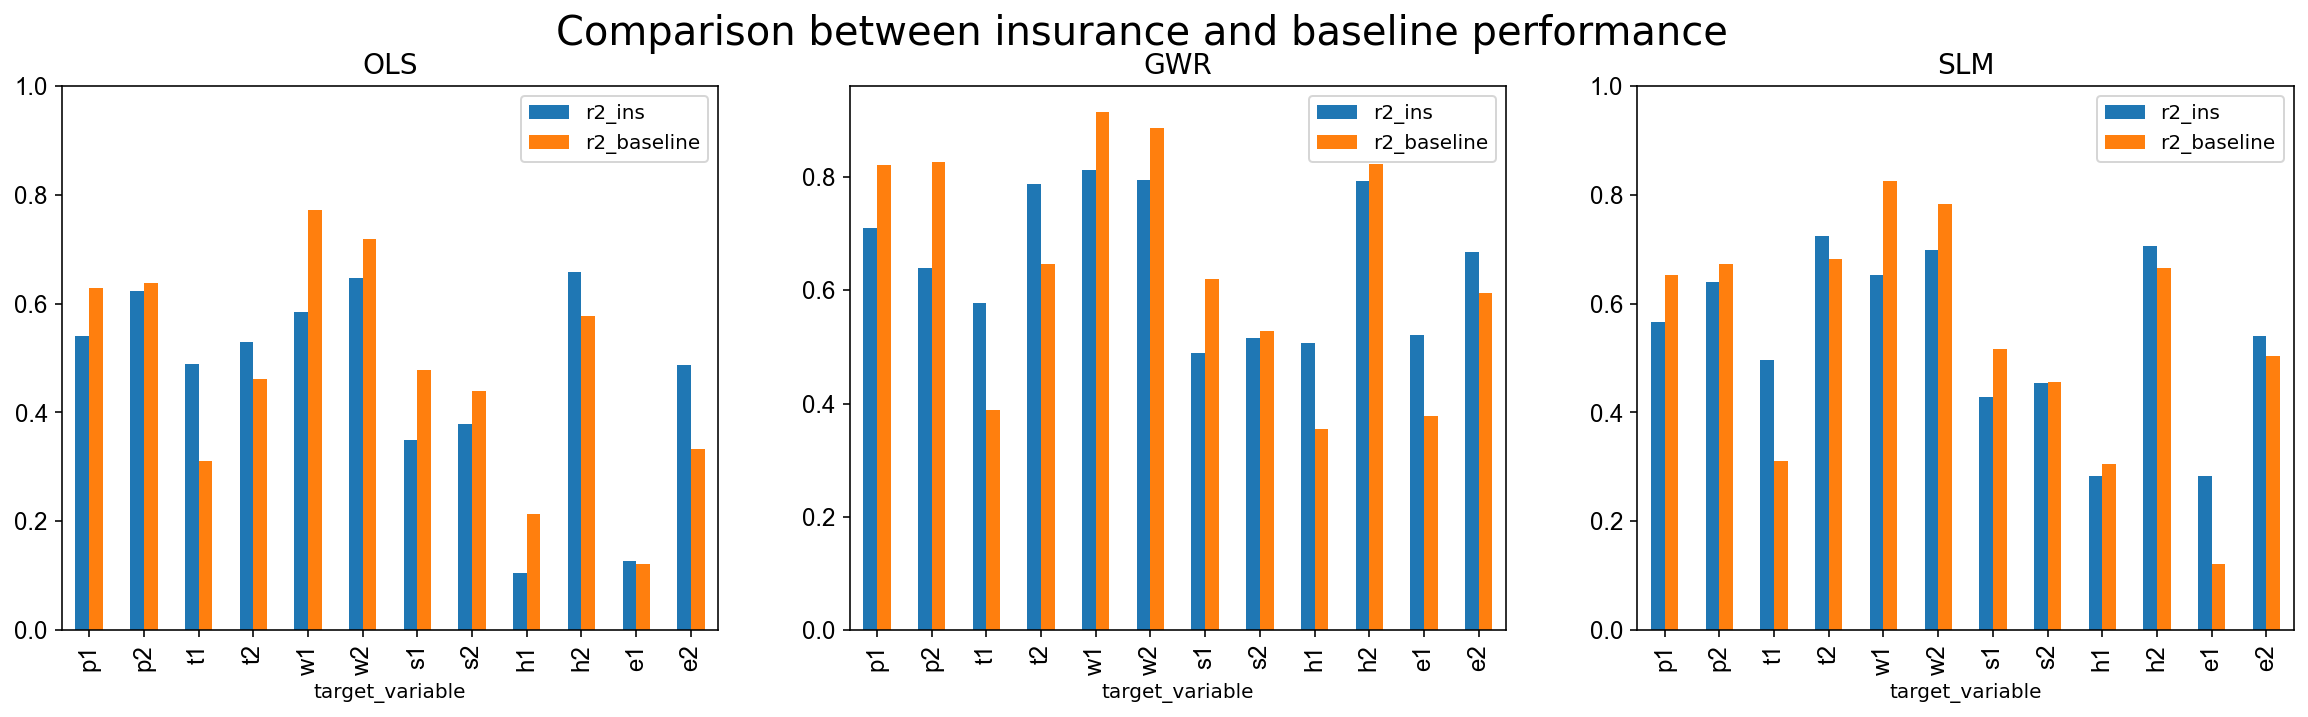

In [33]:
f, axs = plt.subplots(1,3, figsize=(20, 5))
ax0 = axs[0]
ax0 = setFont(ax0, 'Arial', 12)
p1 = mergeBaselineResults(df_r2, df_r2_b, 'OLS')
p1.plot.bar(x= 'target_variable', ax=ax0)
ax0.set_ylim((0,1))
ax0.set_title('OLS', size=14)

ax1 = axs[1]
ax1 = setFont(ax1, 'Arial', 12)
ax1.set_title('GWR', size=14)
p2 = mergeBaselineResults(df_r2, df_r2_b, 'GWR')
p2.plot.bar(x= 'target_variable', ax=ax1)


ax2 = axs[2]
ax2 = setFont(ax2, 'Arial', 12)
ax2.set_title('SLM', size=14)

p3 = mergeBaselineResults(df_r2, df_r2_b, 'SLM')
p3.plot.bar(x= 'target_variable', ax=ax2)
ax2.set_ylim((0,1))



f.suptitle('Comparison between insurance and baseline performance', size=20);
# or plt.suptitle('Main title')



In [34]:
f.savefig('../Response/figures/comparison0.pdf',dpi=300,bbox_inches='tight')

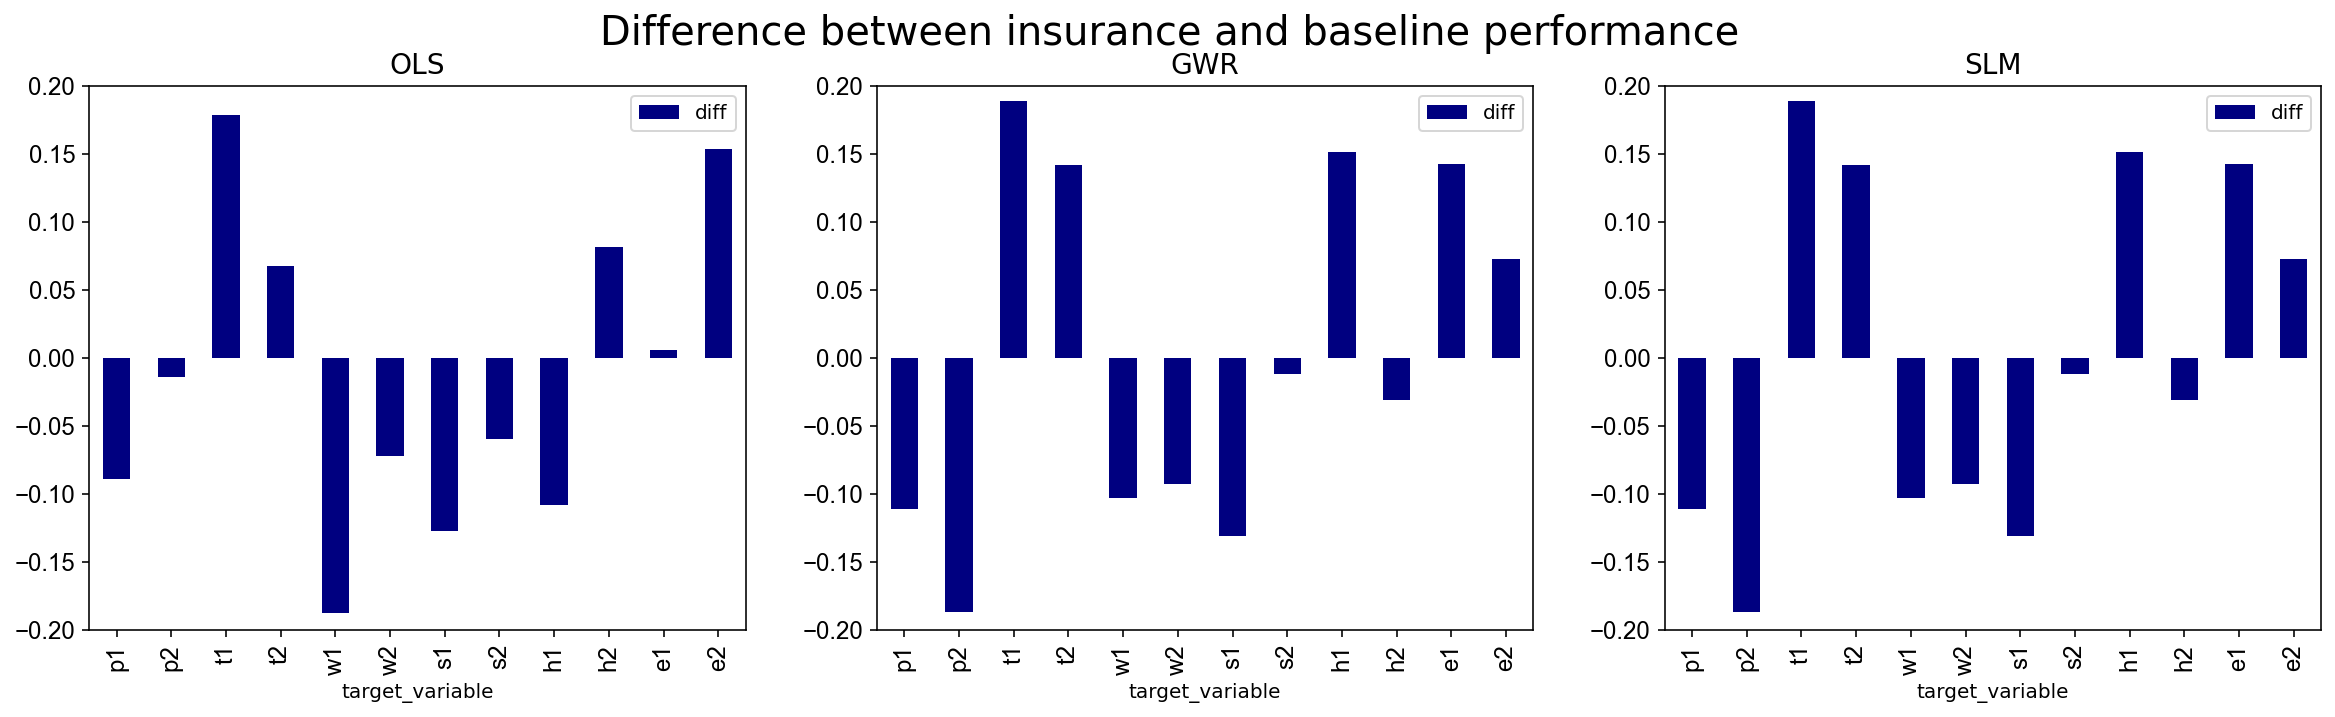

In [35]:
f, ax = plt.subplots(1,3, figsize=(20, 5))
ax0 = ax[0]
ax0 = setFont(ax0, 'Arial', 12)
p1 = mergeBaselineResults(df_r2, df_r2_b, 'OLS')
p1['diff'] = p1['r2_ins']-p1['r2_baseline']
p1.plot.bar(x= 'target_variable', y = 'diff' , ax=ax0, color='navy')
ax0.set_ylim((-.2,.2))
ax0.set_title('OLS', size=14)



ax1 = ax[1]
ax1 = setFont(ax1, 'Arial', 12)
p2 = mergeBaselineResults(df_r2, df_r2_b, 'GWR')
p2['diff'] = p2['r2_ins']-p2['r2_baseline']
p2.plot.bar(x= 'target_variable',y='diff', ax=ax1, color='navy')
ax1.set_ylim((-.2,.2))
ax1.set_title('GWR', size=14)



ax2 = ax[2]
ax2 = setFont(ax2, 'Arial', 12)
p3 = mergeBaselineResults(df_r2, df_r2_b, 'SLM')
p3['diff'] = p3['r2_ins']-p3['r2_baseline']
p2.plot.bar(x= 'target_variable',y='diff', ax=ax2, color='navy')
ax2.set_ylim((-.2,.2))
ax2.set_title('SLM', size=14)
f.suptitle('Difference between insurance and baseline performance', size=20);# or plt.suptitle('Main title')


In [36]:
f.savefig('../Response/figures/comparison.pdf',dpi=300,bbox_inches='tight')

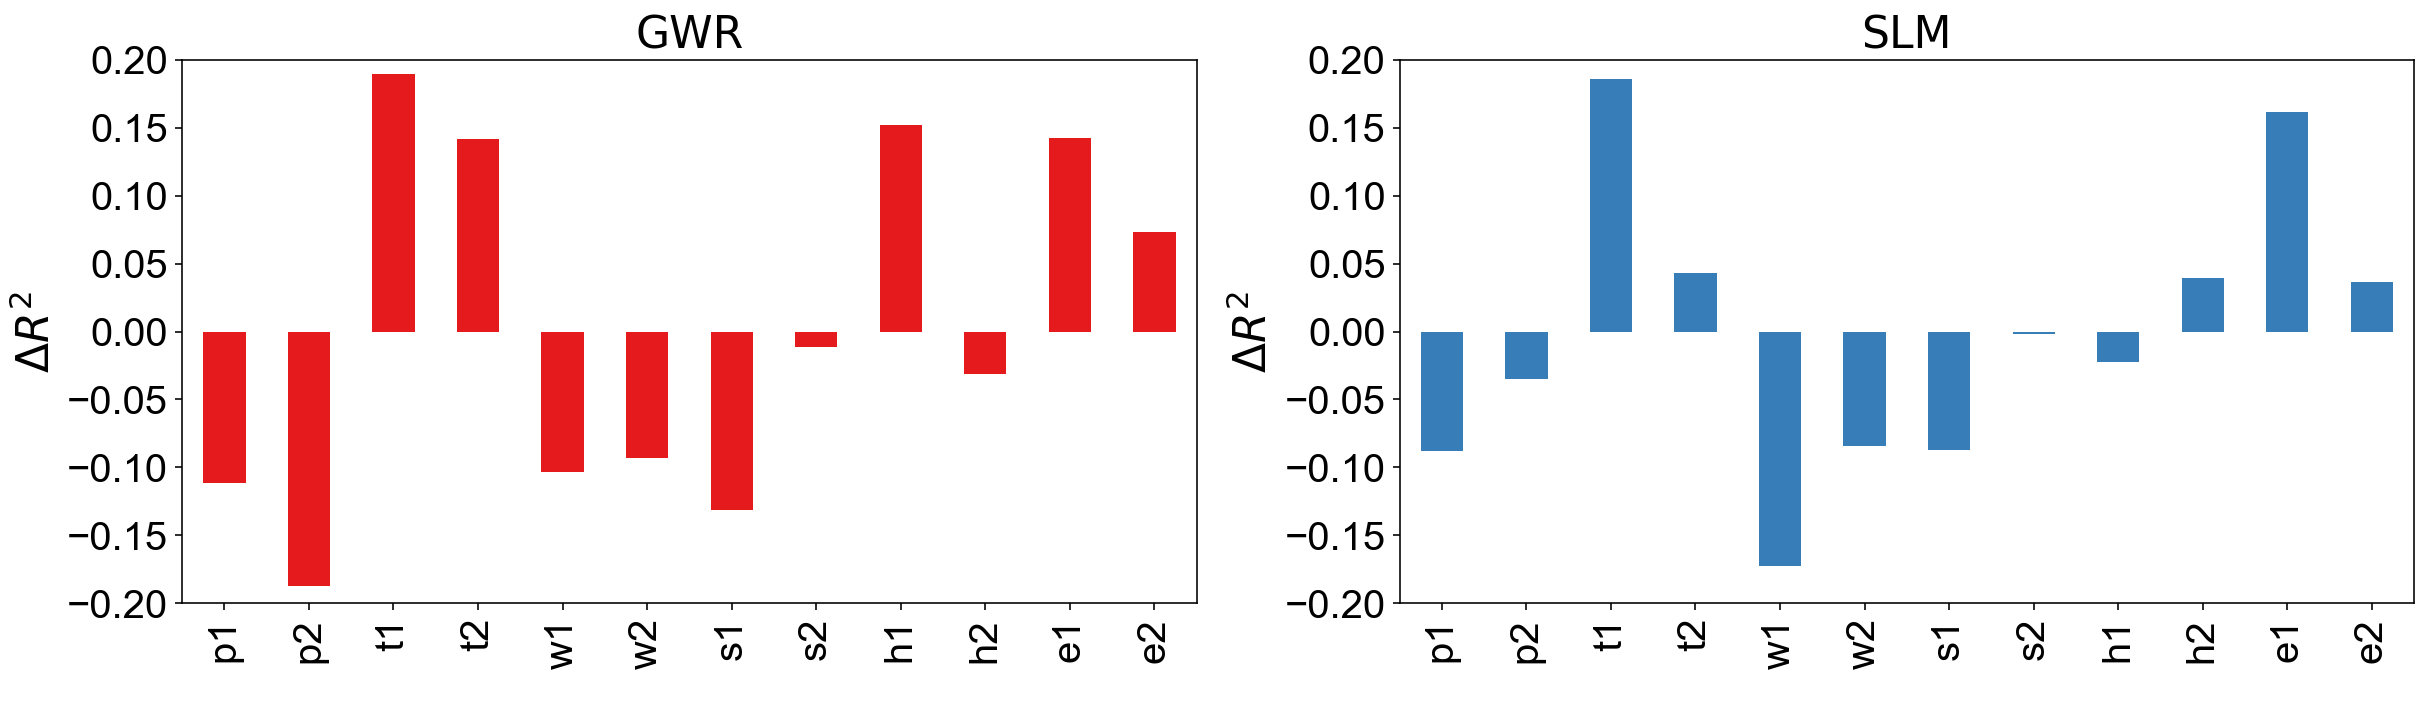

In [37]:
f, ax = plt.subplots(1,2, figsize=(20, 5))

ax1 = ax[0]
ax1 = setFont(ax1, 'Arial', 20)
p2 = mergeBaselineResults(df_r2, df_r2_b, 'GWR')
p2['diff'] = p2['r2_ins']-p2['r2_baseline']
p2.plot.bar(x= 'target_variable',y='diff', ax=ax1, color = sns.color_palette("Set1", 1)[0])
ax1.set_ylim((-.2,.2))
ax1.set_title('GWR', size=22)
ax1.set_xlabel(' ')
ax1.set_ylabel(r'$\Delta R^2$', size=22)
ax1.get_legend().remove()

ax2 = ax[1]
ax2 = setFont(ax2, 'Arial', 20)
p3 = mergeBaselineResults(df_r2, df_r2_b, 'SLM')
p3['diff'] = p3['r2_ins']-p3['r2_baseline']
p3.plot.bar(x= 'target_variable',y='diff', ax=ax2, color = sns.color_palette("Set1", 2)[1])
ax2.set_ylim((-.2,.2))
ax2.set_title('SLM', size=22)
ax2.set_xlabel(' ')
ax2.set_ylabel(r'$\Delta R^2$', size=22)
ax2.get_legend().remove()



In [38]:
f.savefig('../PaperV1/figures/newFigure4.pdf',dpi=300,bbox_inches='tight')

### 4.2 Confidence Intervals and Models Parameters

In [39]:
def compute_conf_slm(model):
    alpha = 0.05
    df_resid = model.n - model.k
    q = scipy.stats.t.ppf(1 - alpha / 2, df_resid)
    conf_low,conf_high=[],[]
    for i in range(len(model.betas)):
            conf_low.append(model.betas[i,0] - q * model.std_err[i]) 
            conf_high.append(model.betas[i,0] + q * model.std_err[i])
    return conf_low,conf_high 

ols_stats,gwr_stats,slm_stats={},{},{}

for vv in selected_models:
    est_ols,est_gwr,est_slm=selected_models[vv]
    cols=['features', 'pvalue','coef','conf_inter','std_error']
    ##ols
    dfaux=pd.DataFrame()
    dfaux['features'] = ['Intercept']+selected_feats[vv]
    dfaux['pvalue'] = est_ols.pvalues
    dfaux['coef'] = est_ols.params
    dfaux['conf_inter_low']=est_ols.conf_int()[:,0]
    dfaux['conf_inter_high']=est_ols.conf_int()[:,1]
    dfaux['std_err'] = est_ols.bse
    dfaux['tvalues'] = est_ols.tvalues 
    ols_stats[vv]=dfaux
    #gwr
    dfaux=pd.DataFrame()
    dfaux['features'] = ['Intercept']+selected_feats[vv]
    dfaux['coef_mean'] = np.mean(est_gwr.params,axis=0)
    dfaux['coef_std'] = np.std(est_gwr.params,axis=0)
    dfaux['coef_min'] = np.min(est_gwr.params,axis=0)
    dfaux['coef_median'] = np.median(est_gwr.params,axis=0)
    dfaux['coef_max'] = np.max(est_gwr.params,axis=0)
    
    dfaux['std_err_mean'] = np.mean(est_gwr.bse,axis=0)
    dfaux['std_err_std'] = np.std(est_gwr.bse,axis=0)
    dfaux['std_err_min'] = np.min(est_gwr.bse,axis=0)
    dfaux['std_err_median'] = np.median(est_gwr.bse,axis=0)
    dfaux['std_err_max'] = np.max(est_gwr.bse,axis=0)
    gwr_stats[vv]=dfaux
    # slm
    dfaux=pd.DataFrame()
    dfaux['features'] = ['Intercept']+selected_feats[vv]+['W_dep_var']
    dfaux['coef'] = est_slm.betas
    dfaux['std_err'] = est_slm.std_err
    cf_low,cf_high = compute_conf_slm(est_slm)
    dfaux['conf_inter_low'] = cf_low
    dfaux['conf_inter_high'] = cf_high
    dfaux['z_stat'] = np.array(est_slm.z_stat)[:,0]
    dfaux['probability'] = np.array(est_slm.z_stat)[:,1]
    slm_stats[vv]=dfaux

In [40]:
ols_stats['p1']

features        pvalue          coef  conf_inter_low  conf_inter_high  \
0  Intercept  1.000000e+00  2.602085e-16       -0.104287         0.104287   
1         f3  1.066877e-01 -1.289737e-01       -0.285961         0.028014   
2         f4  1.023676e-14  4.884720e-01        0.375122         0.601822   
3         f7  4.070349e-06  2.928070e-01        0.171546         0.414068   
4        f23  2.319292e-01 -9.909466e-02       -0.262167         0.063977   

    std_err       tvalues  
0  0.052818  4.926501e-15  
1  0.079510 -1.622116e+00  
2  0.057408  8.508733e+00  
3  0.061415  4.767645e+00  
4  0.082591 -1.199820e+00

In [41]:
gwr_stats['p1']

features  coef_mean  coef_std  coef_min  coef_median  coef_max  \
0  Intercept   0.032225  0.181209 -0.414950     0.036713  0.342743   
1         f3  -0.180407  0.187792 -0.485580    -0.213625  0.459201   
2         f4   0.555690  0.114220  0.115245     0.574955  0.692781   
3         f7   0.285764  0.164659 -0.074130     0.266848  0.582421   
4        f23  -0.039868  0.268650 -0.998032    -0.035090  0.418989   

   std_err_mean  std_err_std  std_err_min  std_err_median  std_err_max  
0      0.110482     0.064141     0.068775        0.083535     0.432978  
1      0.145152     0.055521     0.102699        0.127754     0.499057  
2      0.111293     0.039702     0.083245        0.095768     0.261343  
3      0.109095     0.028768     0.084164        0.099484     0.238774  
4      0.153158     0.046407     0.115791        0.144356     0.528312

In [42]:
slm_stats['p1']

features      coef   std_err  conf_inter_low  conf_inter_high    z_stat  \
0  Intercept -0.003286  0.050728       -0.103451         0.096879 -0.064781   
1         f3 -0.118668  0.077198       -0.271098         0.033763 -1.537183   
2         f4  0.460437  0.065207        0.331685         0.589190  7.061208   
3         f7  0.264955  0.068354        0.129987         0.399922  3.876219   
4        f23 -0.108666  0.079965       -0.266560         0.049228 -1.358917   
5  W_dep_var  0.019310  0.024174       -0.028423         0.067043  0.798778   

    probability  
0  9.483485e-01  
1  1.242484e-01  
2  1.650611e-12  
3  1.060924e-04  
4  1.741730e-01  
5  4.244192e-01

**Lets look at the selected features for each variable and double-check that the regressor for outcome X doesn’t involve explanatory variables that are related to X in an obvious way** 
    
   **Obvious relationships:**
    
    - 'Fraction of foreigners'
        Fraction of foreigners
    - 'Fraction of beneficiaries of the social assistance'
        unemployment rate
    - 'Unemployment rate'
        unemployment rate 
    - 'Unemployment rate between women'
        unemployment rate
    - 'Vacancy rate (%)'
    Fraction of owners (house)
    
   **Variables without obvious relathinships:**

    - 'Building area (%)'
    - 'Green area (%)'
    - 'Average area per inhabitant in square meters'
    - 'Municipal debt'
    - 'Fraction of investment in culture'
    - 'Cars per 1000 inhabitants'
    - 'Fraction of commuters using public transportation'

<a id="increasingc"></a> 
# 5 Inceasing Complexity
* back to [Table of Contents](#toc)

**Now we can asses permormance in inreasing complexity models for the variables that have obvious relationships with some features**

In [43]:
# Selected features the variables we want to further explore
assess_variables={'p1':['f4', 'f3', 'f7', 'f23'],
                'p2':['f1', 'f9', 'f13', 'f15', 'f23'],
                'w1':['f1', 'f4', 'f7', 'f13', 'f23'],
                'w2':['f1', 'f4', 'f6', 'f7', 'f9', 'f16', 'f19', 'f23', 'f33'],
                'h1':['f3', 'f20']}

In [44]:
r2_increasing_complexity={}

for vv in assess_variables:
    
    cols=['OLS','GWR','SLM']
    df_tmp=pd.DataFrame(columns=cols)
    
    print('-------'+vv+'---------')
    
    varnames=[]
    for i in assess_variables[vv]:
        varnames.append(i)
    
        est_gwr = run_GWR(dfData,vv,varnames)
        est_ols = run_OLS(dfData,vv,varnames)
        est_slm = run_SLM(dfData,vv,varnames)
        
        aux=[get_r2(est_ols),get_r2(est_gwr),get_r2(est_slm)]
        
        df_tmp = df_tmp.append(pd.DataFrame(columns=cols,data=[aux]),ignore_index=True)
    r2_increasing_complexity[vv]=df_tmp

-------p1---------
-------p2---------
-------w1---------
-------w2---------
-------h1---------


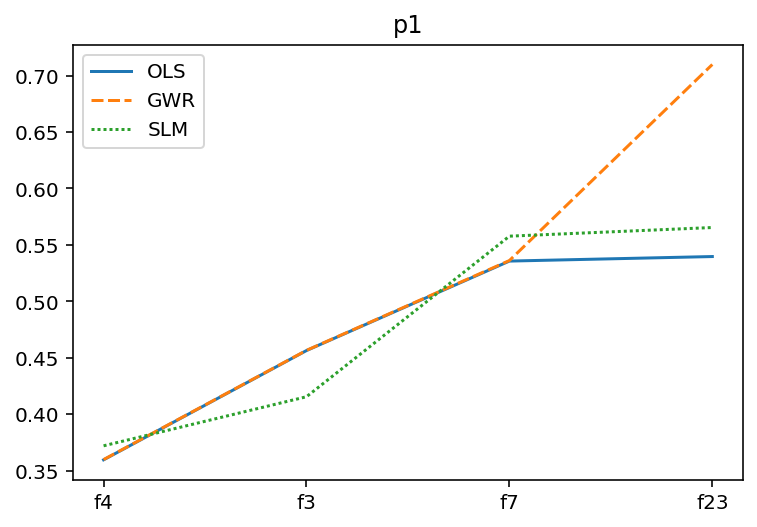

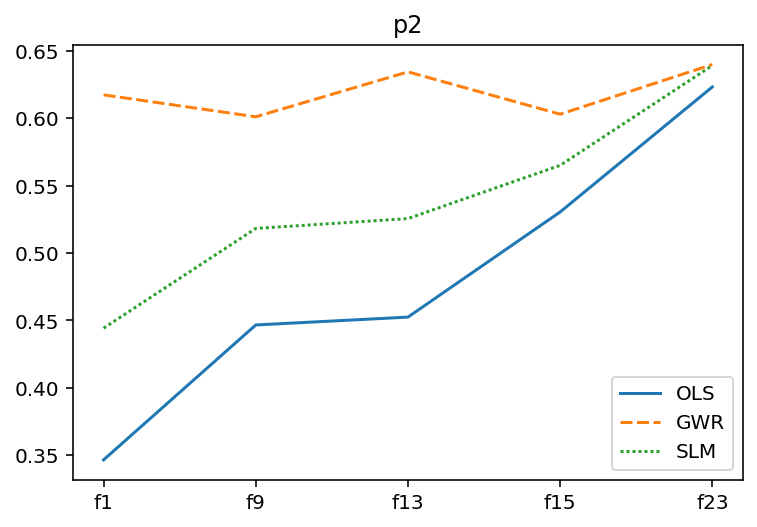

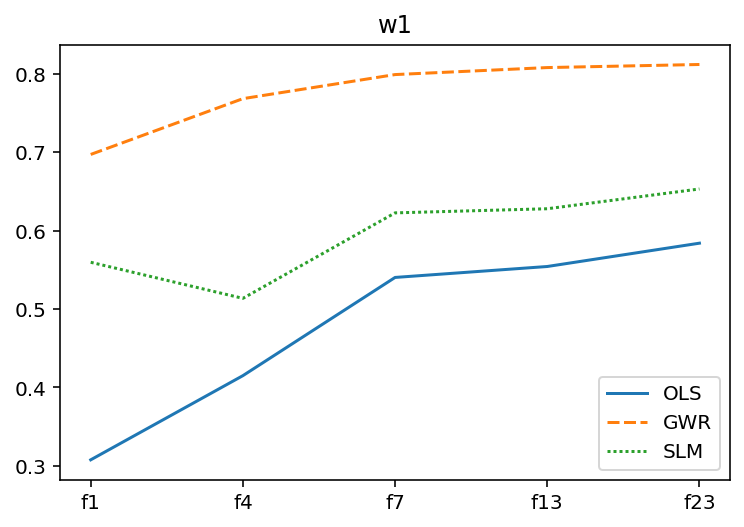

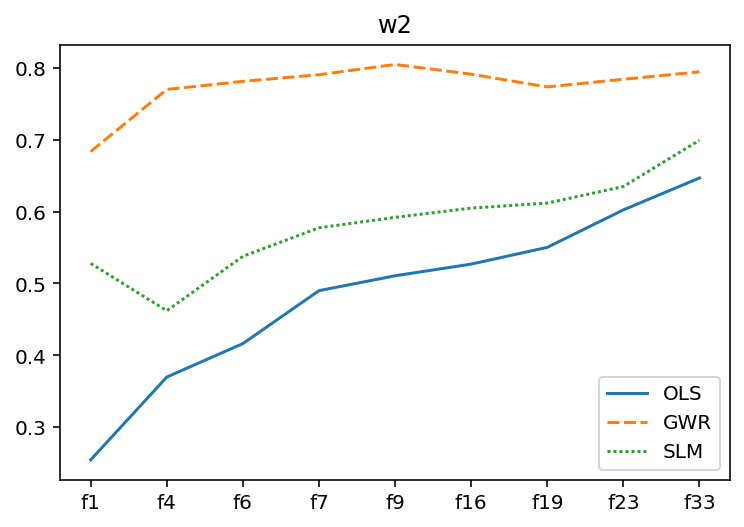

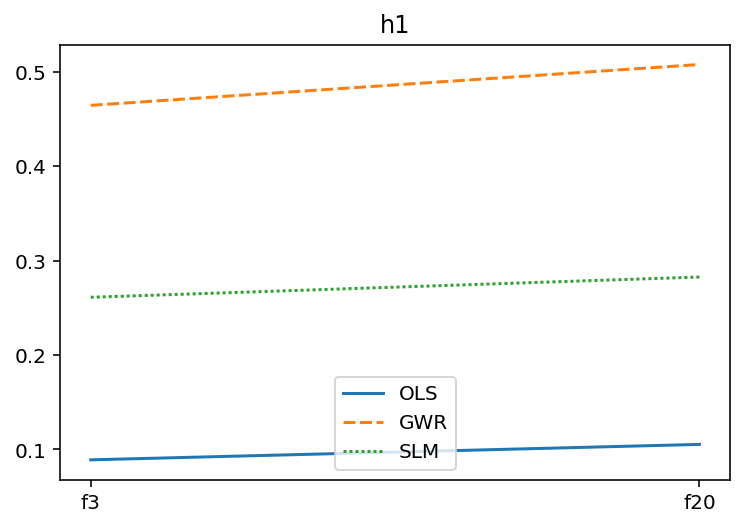

In [45]:
for vv in assess_variables:
    fig,ax=plt.subplots()
    sns.lineplot(data=r2_increasing_complexity[vv])
    ax.set_title(vv)
    ax.set_xticks(range(len(assess_variables[vv])))
    ax.set_xticklabels(assess_variables[vv])

<a id="crossval"></a>
# 6. Cross Validation
* back to [Table of Contents](#toc)

In [46]:
def cross_validation(df,case,selected_feats=selected_feats):
    
    tmp=[]
    for train_index, test_index in generator.split(df, df['categories']):
        
        df_train = df.iloc[train_index]
        df_test = df.iloc[test_index]
        c_test=list(df_test.g_coords)
        
        for vv in selected_feats:
            Xtrain,ytrain = extract_scale_features(df_train,vv,selected_feats[vv])
            Xtest,ytest = extract_scale_features(df_test,vv,selected_feats[vv])
            
            if case == 'GWR':
                est_gwr = run_GWR(df_train,vv,selected_feats[vv])
                yest        = np.sum(sm.add_constant(Xtrain) * est_gwr.params, 
                                     axis=1).reshape((-1, 1))
                # predict in the testing locations             
                Res    = GWR.predict(est_gwr.model, np.array(c_test), np.array(ytest) )
                ypred  = np.sum(sm.add_constant(Xtest) * Res.params, axis=1).reshape((-1, 1))
                tmp.append([vv,r2_score(ytrain, yest),r2_score(ytest,ypred)]) ## training r squared
                
            if case == 'OLS':
                
                est_ols = run_OLS(df_train,vv,selected_feats[vv])
                yest = est_ols.predict(sm.add_constant(Xtrain))
                ypred = est_ols.predict(sm.add_constant(Xtest))
                
                tmp.append([vv,r2_score(ytrain, yest),r2_score(ytest,ypred)]) ## training r squared
                
            if case == 'SLM':
                est_slm = run_SLM(df_train,vv,selected_feats[vv],W = generate_W_knn(df_train))
                yW = [float(np.dot(generate_W_knn(df_train.append([df_test.iloc[i]])).full()[0][-1,:][:-1],ytrain))
                      for i in range(df_test.shape[0])]
                x_aux = np.hstack([sm.add_constant(Xtest),np.array(yW).reshape(-1,1)])
                yest = est_slm.predy
                ypred  = np.matmul(x_aux , est_slm.betas)
                
                tmp.append([vv,r2_score(ytrain, yest),r2_score(ytest,ypred)])
                
    return pd.DataFrame(columns=['target_variable','r2Tr','r2Val'],data=tmp)

In [47]:
for case in ['OLS','GWR','SLM']:
    df_crossval=cross_validation(dfData,case)

    r2Std=df_crossval.groupby('target_variable',sort=False).apply(np.std).values
    r2Mean=df_crossval.groupby('target_variable',sort=False).apply(mean).values

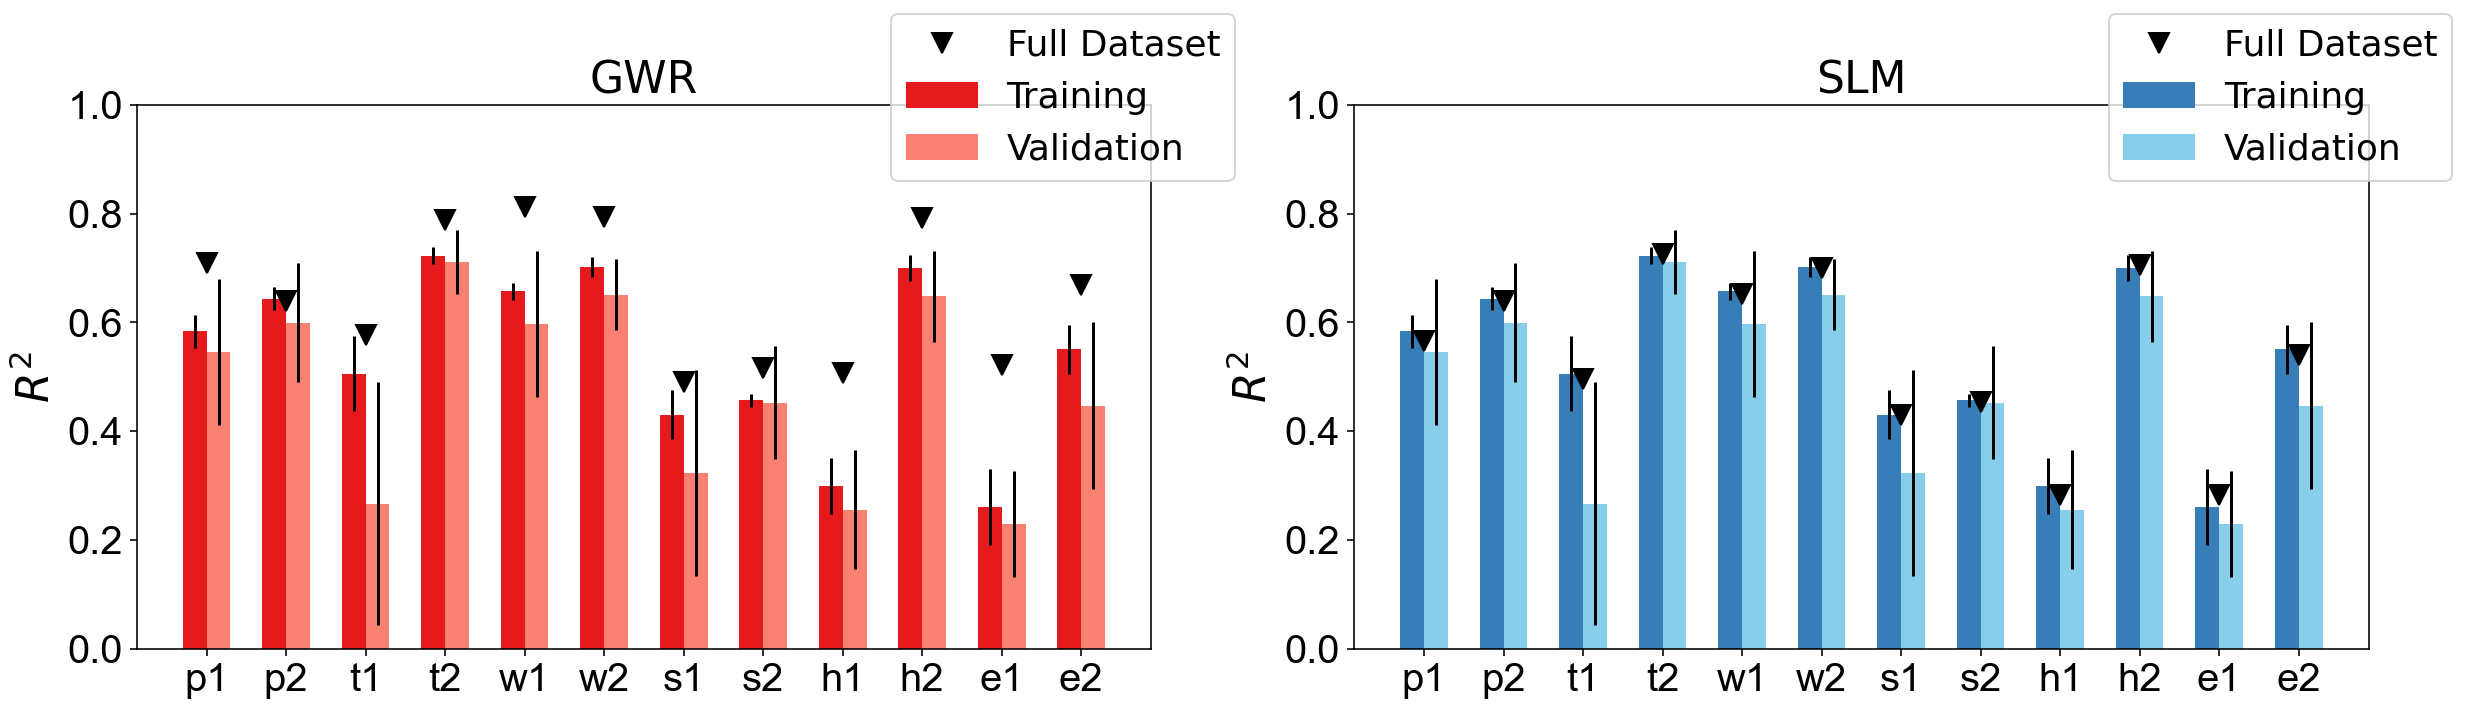

In [48]:
f, axs = plt.subplots(1,2, figsize=(20, 5))
for i, case in enumerate(['GWR','SLM']):
    ax = axs[i]
    xt = np.arange(0,len(target_variables.keys()))
    ax = setFont(ax, 'Arial', 20)
    width = 0.3
    if i == 0:
        c1 = sns.color_palette("Set1", 1)[0]
        c2 = sns.color_palette("Set1", 8)[2]
        c2 = 'salmon'
    if i == 1:
        c1 = sns.color_palette("Set1", 2)[1]
        c2 = sns.color_palette("Set1", 8)[2]
        c2 = 'skyblue'
    p0 = ax.bar(xt-width/2, r2Mean[:,0], width, align='center',  yerr=r2Std[:,0],label='Training', color=c1)
    p1 = ax.bar(xt+width/2, r2Mean[:,1], width, align='center',  yerr=r2Std[:,1],label='Validation', color=c2)
    p2 = ax.plot(xt,df_r2[df_r2.model==case].r2.values, lw=0, marker='v', 
                 markersize=10, color='black',label='Full Dataset')
    ax.set_xticks(xt)
    ax.set_xticklabels(list(target_variables.keys()))
    #ax.set_xticks(xt,list(target_variables.keys()))
    ax.legend(fontsize=18, bbox_to_anchor=(1.1, 1.2))

    ax.set_ylim([0,1]);
    ax.set_title(case, size = 22);
    ax.set_ylabel('$R^2$', size = 22);
    #if i ==0:
    #    ax.get_legend().remove()

In [49]:
#f.savefig('../PaperV1/figures/figur3_new_bottom.pdf',dpi=300,bbox_inches='tight')

<a id="casestudy"></a>
# 7. Case Study - Public Transport
* back to [Table of Contents](#toc)

In [50]:
varnames = feature_selection(dfData,'t2')

In [51]:
print('Predictors for Public Transportation')
for i in varnames:
    print(i+': '+features_dict[i])

Predictors for Public Transportation
f3: Fraction of owners (house)
f6: Market Share
f20: Percent of insured cars
f22: 95th percentile  class of fornitures
f25: Average Building Insured Sum


In [52]:
ols_stats['t2']

features        pvalue          coef  conf_inter_low  conf_inter_high  \
0  Intercept  1.000000e+00  1.804112e-16       -0.105828         0.105828   
1         f3  1.692871e-07 -3.576087e-01       -0.486814        -0.228403   
2         f6  4.352146e-03 -1.594972e-01       -0.268408        -0.050586   
3        f20  3.550151e-06 -3.138352e-01       -0.442936        -0.184735   
4        f22  9.418764e-07  2.974445e-01        0.182217         0.412672   
5        f25  1.839962e-02  1.361844e-01        0.023261         0.249108   

    std_err       tvalues  
0  0.053596  3.366103e-15  
1  0.065436 -5.465031e+00  
2  0.055158 -2.891647e+00  
3  0.065383 -4.799963e+00  
4  0.058357  5.096983e+00  
5  0.057190  2.381270e+00

In [53]:
gwr_stats['t2']

features  coef_mean  coef_std  coef_min  coef_median  coef_max  \
0  Intercept   0.005009  0.313103 -1.168885     0.133277  0.338831   
1         f3  -0.305712  0.156330 -0.649465    -0.248316  0.006868   
2         f6  -0.235517  0.217932 -0.896059    -0.222656  0.201920   
3        f20  -0.301310  0.200646 -0.586368    -0.376415  0.541239   
4        f22   0.197482  0.130562 -0.018812     0.174539  0.580249   
5        f25   0.273592  0.115480 -0.324989     0.302387  0.406676   

   std_err_mean  std_err_std  std_err_min  std_err_median  std_err_max  
0      0.141072     0.131572     0.066884        0.095930     0.606734  
1      0.134481     0.057944     0.083171        0.113203     0.490524  
2      0.158423     0.157852     0.063246        0.096714     0.918120  
3      0.136634     0.101718     0.098457        0.115445     1.162273  
4      0.116148     0.090582     0.067749        0.091312     0.799946  
5      0.127842     0.047243     0.085345        0.113833     0.488532

In [54]:
slm_stats['t2']

features      coef   std_err  conf_inter_low  conf_inter_high    z_stat  \
0  Intercept -0.097238  0.041939       -0.180052        -0.014425 -2.318577   
1         f3 -0.238735  0.051208       -0.339852        -0.137617 -4.662020   
2         f6 -0.100886  0.042002       -0.183824        -0.017949 -2.401960   
3        f20 -0.260598  0.049487       -0.358316        -0.162881 -5.266033   
4        f22  0.120189  0.048871        0.023687         0.216691  2.459304   
5        f25  0.090539  0.043271        0.005095         0.175982  2.092368   
6  W_dep_var  0.118942  0.014568        0.090175         0.147709  8.164484   

    probability  
0  2.041798e-02  
1  3.131209e-06  
2  1.630747e-02  
3  1.394036e-07  
4  1.392067e-02  
5  3.640557e-02  
6  3.228132e-16

In [55]:
est_gwr = selected_models['t2'][1]

In [56]:
dfc = gpd.GeoDataFrame(data={'BFS': dfData.BFS,'geometry':dfData.geometry, 'clr': ravel(est_gwr.localR2)})

In [57]:
m=30 #Custom Legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='0.43 - 0.57',markerfacecolor='lightblue', markersize=m),
                   Line2D([0], [0], marker='o', color='w', label='0.57 - 0.66',markerfacecolor='green', markersize=m),
                   Line2D([0], [0], marker='o', color='w', label='0.66 - 0.73',markerfacecolor='orange', markersize=m),
                   Line2D([0], [0], marker='o', color='w', label='0.73 - 0.82',markerfacecolor='purple', markersize=m),
                   Line2D([0], [0], marker='o', color='w', label='0.82 - 0.91',markerfacecolor='brown', markersize=m)]

In [59]:
d = {'fontsize':40, 'loc':2}
m = {'markersize':30}

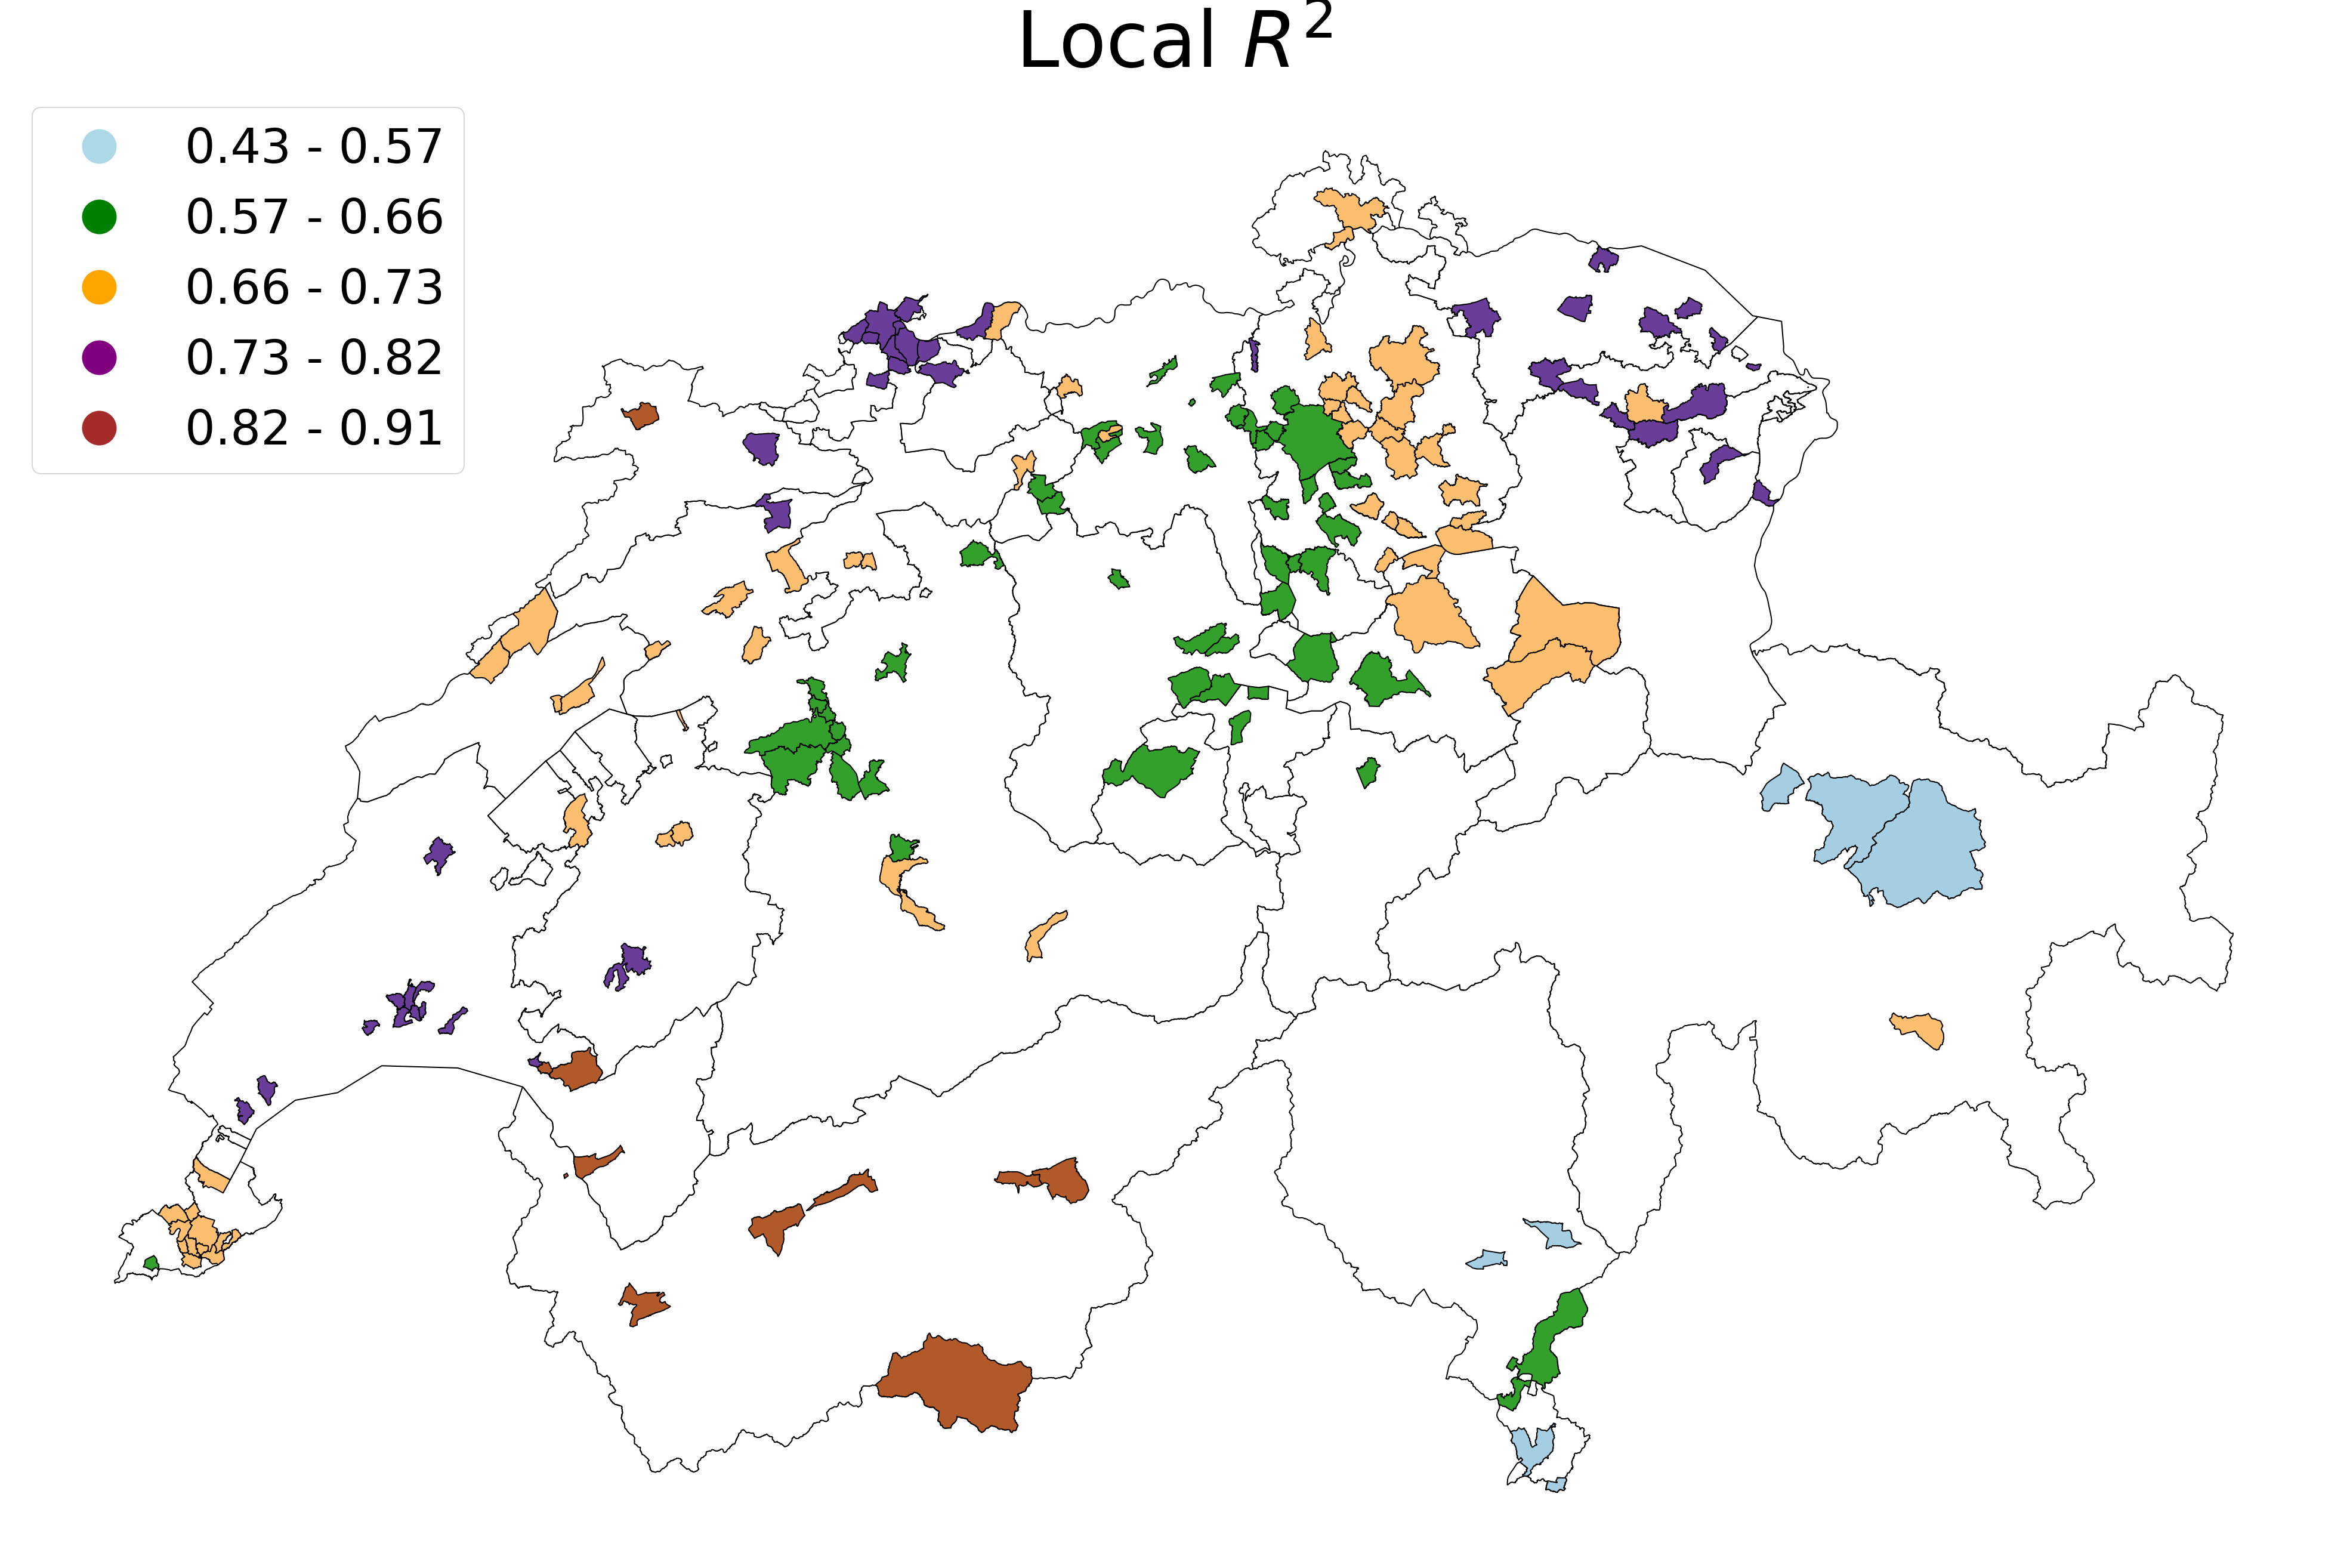

In [60]:
fig, ax=plt.subplots(figsize=(35, 35), facecolor='white', edgecolor='white')

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(40)
    
cantons.plot(ax = ax, color='white', edgecolor='black')
pt= dfc.plot(column='clr', edgecolor='black', markersize=40,
               legend=False, scheme='fisher_jenks',cmap='Paired', ax = ax, legend_kwds= d)

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.set_xticks([])
ax.set_yticks([]);
ax.legend(handles=legend_elements, loc=2,fontsize=40)
ax.set_title('Local $R^2$', size=65)
plt.show()

In [61]:
def plot_map(clr,title):
    mun_color = pd.merge(mun,pd.DataFrame(data={'BFS': dfFeat.BFS, 'clr': clr}),left_on='BFS_NUMMER',right_on='BFS')       
    fig, ax=plt.subplots(figsize=(12, 7), facecolor='white', edgecolor='white')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(12)
    cantons.plot(ax = ax, color='white', edgecolor='black')
    mun_color.plot(ax = ax, column='clr', edgecolor='black',legend=True, scheme='fisher_jenks',cmap='RdYlBu_r')
    ax.set_ylabel('Y [km]',size = 14 ,rotation=90)
    ax.set_xlabel('X [km]',size= 14)
    ax.set_xticklabels(np.round(ax.get_xticks()/1000))
    ax.set_yticklabels(np.round(ax.get_yticks()/1000))
    plt.title(title,fontsize=16)
    plt.show()
    
    return fig

def annotate(target_point,text_location,text):
    plt.annotate(text, target_point, text_location, 'data', \
                arrowprops=dict(arrowstyle="-|>", \
                connectionstyle="angle3", lw=1), \
                size=16, ha="center")

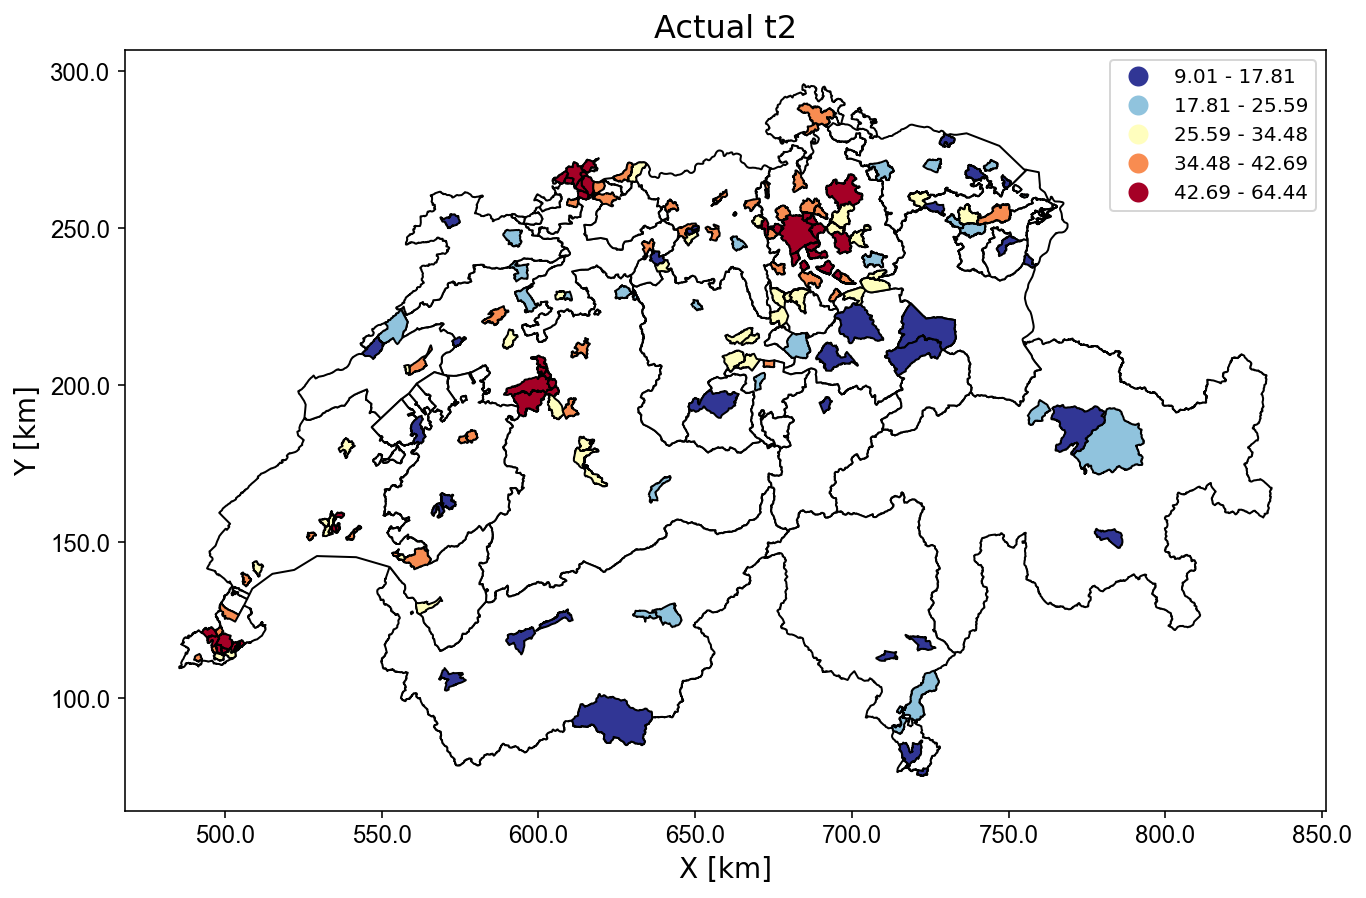

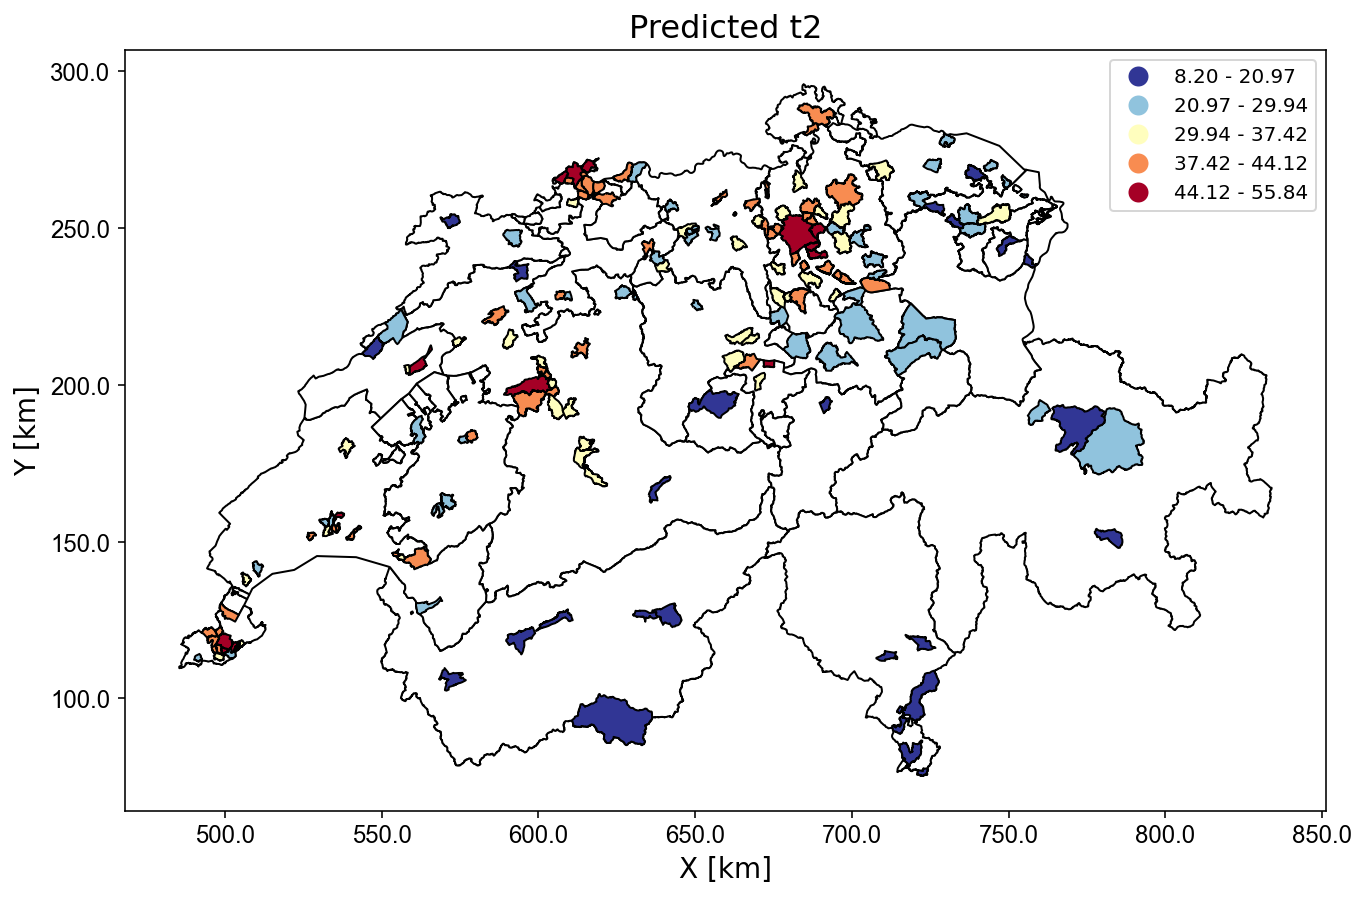

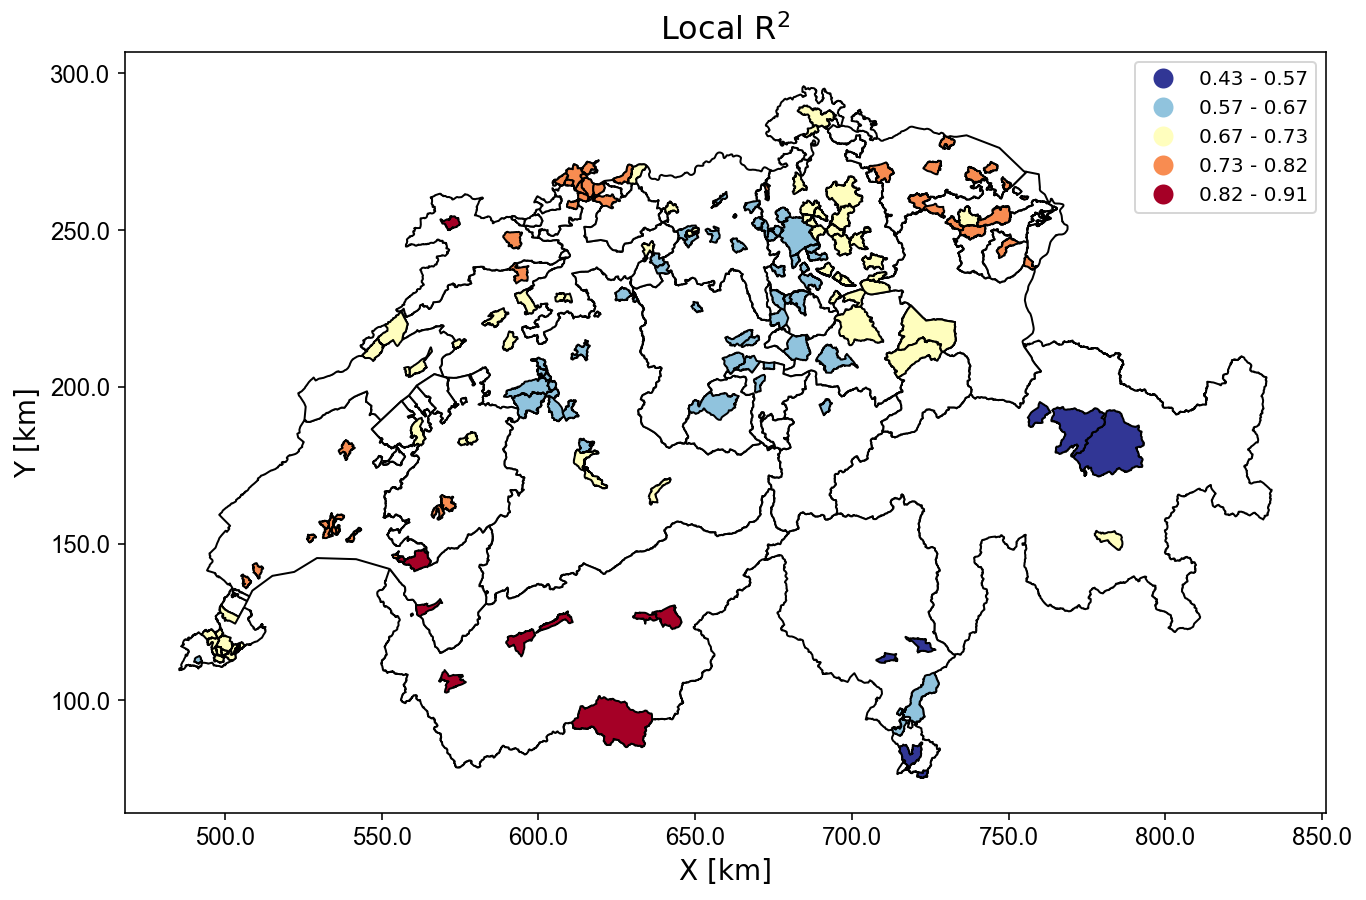

In [62]:
mu=np.mean(dfData['t2'])
std=np.std(dfData['t2'])

tmp=dfData.filter(items=['BFS','t2','CityLaMobiliere'])
tmp['t2_pred']=100*ravel(est_gwr.predy*std+mu)  #Predicted t2 units [%]
tmp['t2']=100*tmp['t2']                             #Actual t2 units [%]
fig=plot_map(tmp['t2'],'Actual t2')
fig=plot_map(tmp['t2_pred'],'Predicted t2')
#fig.savefig('../Paper/figures/predt2.pdf',dpi=300,bbox_inches='tight')

fig=plot_map(ravel(est_gwr.localR2),'Local R$^2$')
#fig.savefig('../Paper/figures/localr2.pdf',dpi=300,bbox_inches='tight')

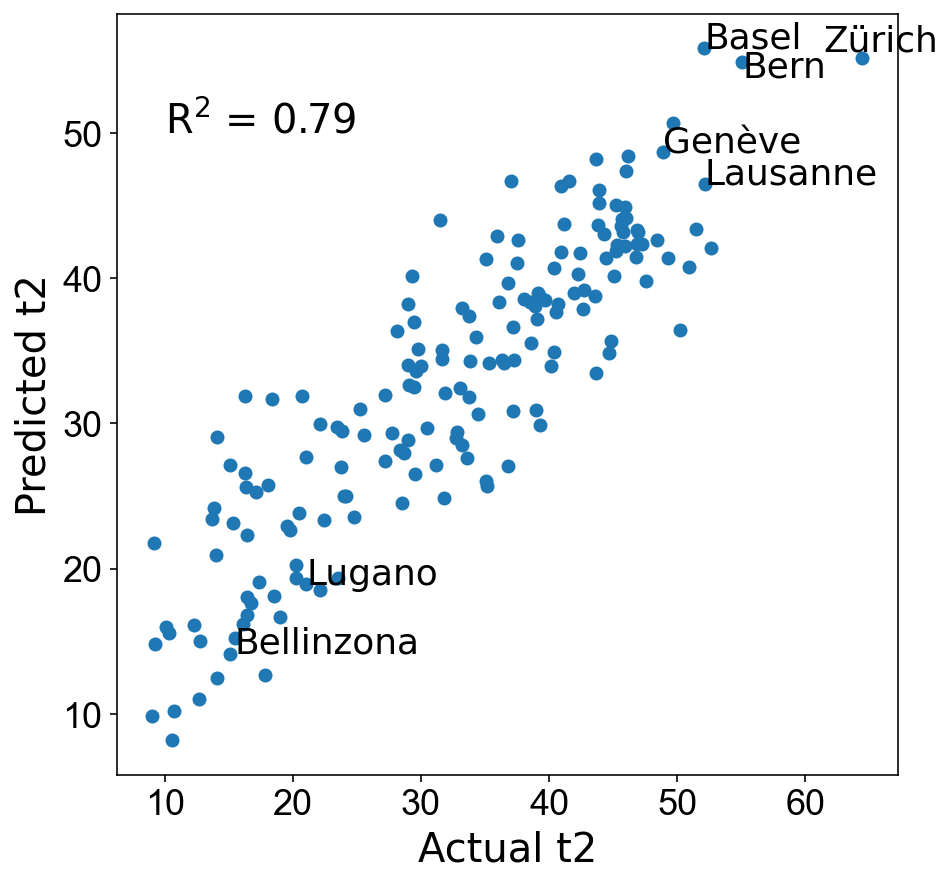

In [63]:
f, ax = plt.subplots(figsize=(7, 7))
ax = setFont(ax, 'Arial', 18)
ax.scatter(tmp['t2'],tmp['t2_pred'])

city_annotate=['Zürich','Genève','Bern','Basel','Lausanne','Lugano','Bellinzona']

#hd=[0,0,0,-5,5]  # displacement for annotation with arrows
#vd=[-5,-15,-5,-5,-5]

hd=[-3,0,0,0,0,0,0,0.5]  #displacement for only text annotation
vd=[0.5,0,-1,0,0,0,-1,-0.5]

for j,city in enumerate(city_annotate): 
    aux=tmp[tmp['CityLaMobiliere']==city]
    #annotate((aux['t2'],aux['t2_pred']),(aux['t2']+hd[j],aux['t2_pred']+vd[j]),city)
    plt.text(aux['t2']+hd[j],aux['t2_pred']+vd[j],city,fontsize=18)
    
plt.text(10,50,"R$^2$ = "+str(round(r2_score(tmp['t2'],tmp['t2_pred']),2)),fontsize=20)
plt.ylabel("Predicted t2", fontsize=20)
plt.xlabel("Actual t2", fontsize=20)
plt.show()

<a id="answers"></a>
# 8. Answer to reviewers
* back to [Table of Contents](#toc)

### 8.1 Removing Trivial Features

We predict those six target variables by removing the trivial features

In [64]:
target_variables_={
"p1": "Fraction of foreigners",
"p2": "Fraction of beneficiaries of the social assistance",
"t1": "Cars per 1000 inhabitants",
"t2": "Fraction of commuters using public transportation",
"w1": "Unemployment rate",
"w2": "Unemployment rate between women"}

In [65]:
features_dict={"f1" : "unemployment rate",
"f2" : "average age in the muncipality",
"f3" : "Fraction of owners (house)",
"f4" :  "Fraction of foreigners",
"f5" :  "Avg number of childer for customers with at least one children",
"f6" :  "Market Share",
"f7" :  "fraction of women",
"f8" :  "Number of customers divided by total customers",
"f9" :  "average price of the cars",
"f10" : "95th percentile price of the cars",
"f11" :  "Average Year of the car",
"f12" :  "5th percentile Year of the car",
"f13" :  "Average CCM of the car",
"f14" :  "95th percentile CCM of the car",
"f15" :  "Average number of claims per cars",
"f16" :  "95th percentile number of claims of the car",
"f17" :  "Average sum of claims of the car",
"f18" :  "95th percentile number of price of the car",
"f19" :  "Average sum of class premium of the car",
"f20" :  "Percent of insured cars",
"f21" :  "Average Class of Forniture",
"f22" :  "95th percentile  class of fornitures",
"f23" :  "Avg Number of Rooms",
"f24" :  "95th percentile  number of rooms",
"f25" :  "Average Building Insured Sum",
"f26" :  "95th Building Insured Sum",
"f27" :  "Average Building Year of Constructions",
"f28" :  "5th Percentile Building Year of Constructions",
"f29" :  "Average type of Building",
"f30" :  "Average number of claims per building",
"f31" :  "Average Sum of claims per building",
"f32" :  "95th Sum of claims per building",
"f33" :  "Average Insured Premium",
"f34" :  "95th Sum of Insured Premium"}

In [66]:
selected_feats={}
selected_models={}
g_coords = list(dfData.g_coords.values)
for i,target in enumerate(target_variables):
    varnames = feature_selection(dfData,target)
    if target == 'p1':
        varnames.remove('f4')
    elif target == 'p2':
        varnames.remove('f1')
    elif target == 't1':
        varnames.remove('f20')
    elif target == 't2':
        varnames.remove('f3')
    elif target == 'w1':
        varnames.remove('f1')
    elif target == 'w2':
        varnames.remove('f1')
    selected_feats[target] = varnames
    ##run the different models with the selected variables
    est_ols = run_OLS(dfData,target,varnames)
    est_gwr = run_GWR(dfData,target,varnames)
    est_slm = run_SLM(dfData,target,varnames, W = W_knn)
    selected_models[target] = [est_ols,est_gwr,est_slm]

In [67]:
cols = ['target_variable','model','r2']
df_r2_trivial=pd.DataFrame(columns=cols)
for i,j in zip(selected_models.keys(),selected_models.values()):
    for est, model in zip(j,['OLS','GWR','SLM']):
        df_r2_trivial=df_r2_trivial.append(pd.DataFrame(columns=cols,
                                                        data=[[i,model,get_r2(est)]]),
                                           ignore_index=True)

Text(0.5, 1.0, 'Performance of the models witohout trivial features')

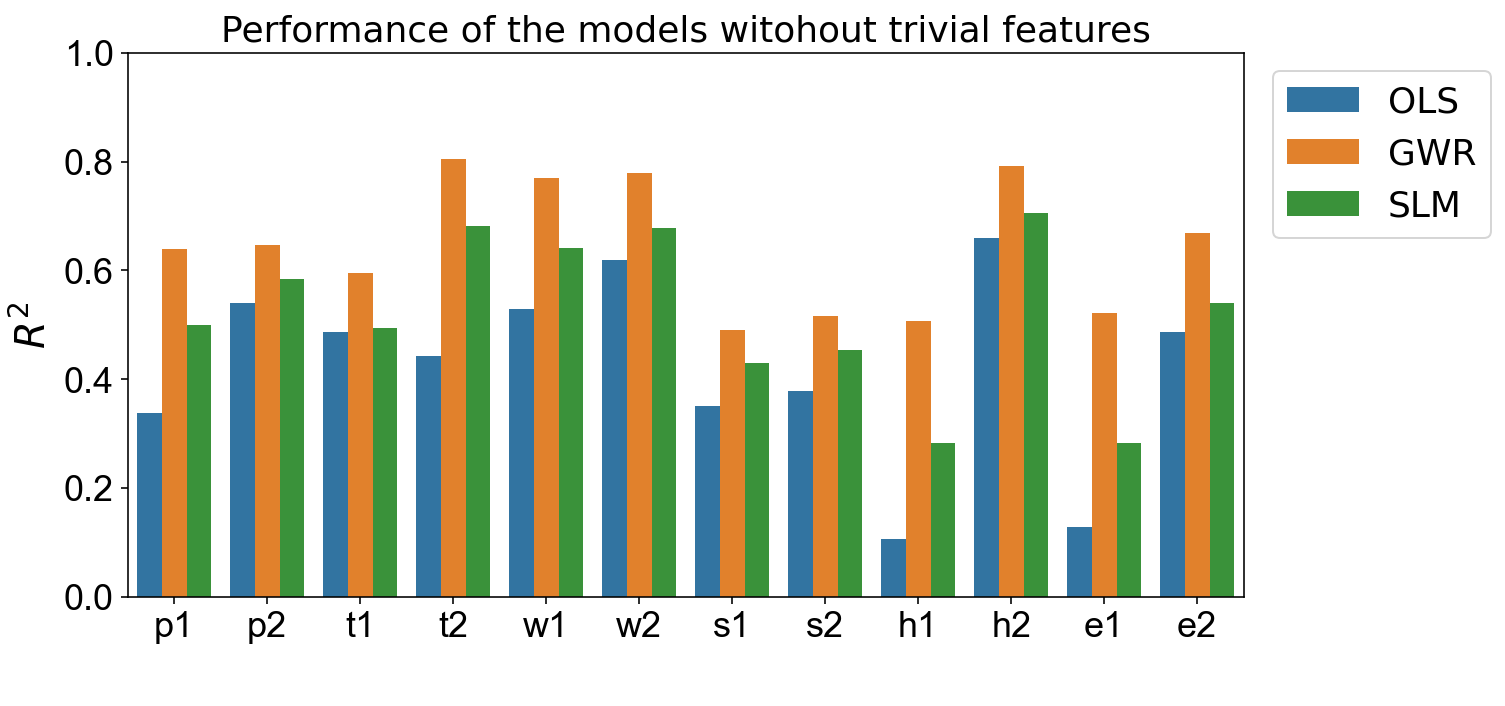

In [68]:
f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
sns.barplot(data=df_r2_trivial,hue='model',x='target_variable',y='r2')
ax.set_ylabel(r'$R^2$', size=20)
ax.set_xlabel(r' ', size=20)
ax.legend(fontsize=18, bbox_to_anchor=(1.01,1))
ax.set_ylim((0,1))
ax.set_title('Performance of the models witohout trivial features', size=18)

In [69]:
df_r2_trivial = df_r2_trivial[df_r2_trivial.index < 18]
tmp = df_r2[df_r2.index < 18]
df_r2_trivial['diff'] = tmp['r2'] - df_r2_trivial['r2'] 

Text(0.5, 1.0, 'Performances variation due to the removal of trivial features')

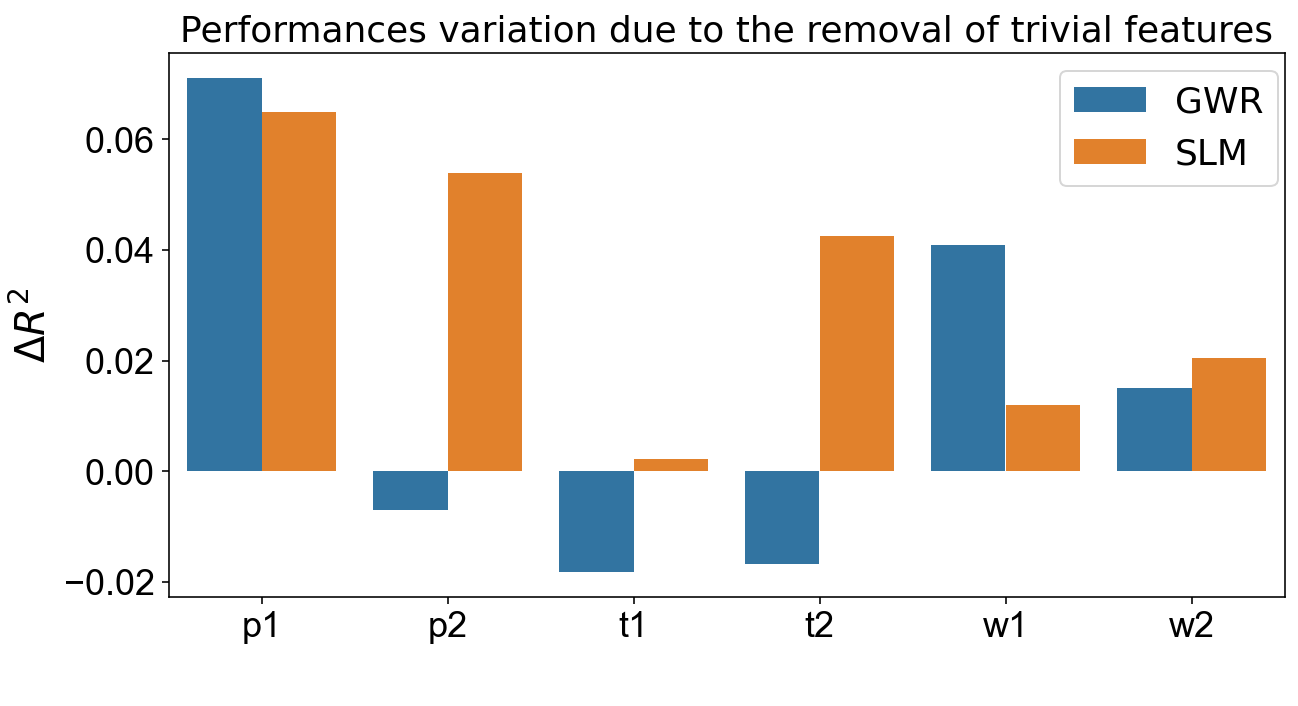

In [70]:
f, ax = plt.subplots(figsize=(10, 5))
ax = setFont(ax, 'Arial', 18)
tmp = df_r2_trivial[df_r2_trivial['model']!='OLS']
sns.barplot(data=tmp,hue='model',x='target_variable',y='diff')
ax.set_ylabel(r'$\Delta R^2$', size=20)
ax.set_xlabel(r' ', size=20)
ax.legend(fontsize=18, bbox_to_anchor=(1.01,1))
ax.set_title('Performances variation due to the removal of trivial features', size=18)

In [71]:
#f.savefig('../PaperV1/figures/deltaR2_new_a.pdf',dpi=300,bbox_inches='tight')

### 8.2 Residuals of the Moran's I

In [72]:
yCol = sd.columns[:-2]

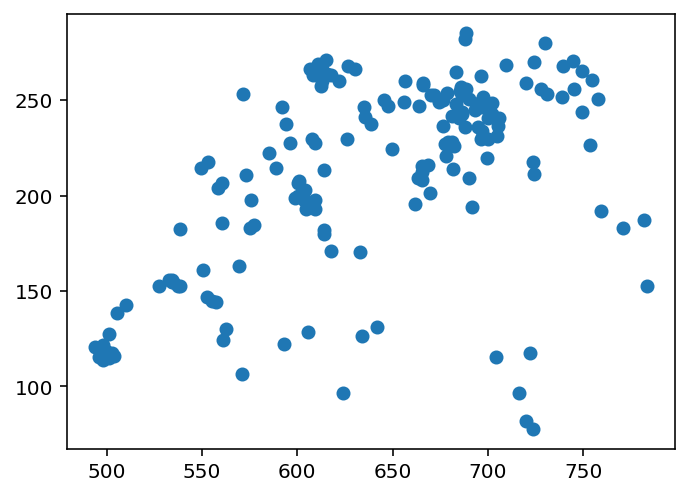

In [73]:
from shapely.geometry import Point 
cords_aux = list(zip(dfData['Xcoord'].values,dfData['Ycoord'].values))
df_res = gpd.GeoDataFrame()
df_res['geometry']=[Point(i) for i in cords_aux]
df_res.plot()
plt.show()

In [74]:
tmp=[]
for idx, ycol in enumerate(yCol):    
    yNorm = scale(np.array(dfData[ycol]).reshape(-1,1) )
    varnames = selected_feats[ycol]
    X = dfData.filter(varnames, axis=1)  ## features
    xNorm = scale(X.values)
    est  = sm.OLS(yNorm, sm.add_constant(xNorm)).fit()
    df_res[ycol+'_res'] = est.resid
    mi=ps.explore.esda.Moran(est.resid,w_gaussian,permutations=9999)
    tmp.append(mi.I)
    tmp.append(mi.p_sim)
    mi=ps.explore.esda.Moran(yNorm,w_gaussian,permutations=9999)
    tmp.append(mi.I)
    tmp.append(mi.p_sim)

In [75]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
df_mori=pd.DataFrame(data=np.reshape(tmp,(-1,4)),columns=['I_res','Pval_res','I_var','Pval_var'],index=yCol)
df_mori

I_res  Pval_res  I_var  Pval_var
p1 0.2893    0.0001 0.3675    0.0001
p2 0.1908    0.0005 0.4483    0.0001
t1 0.1051    0.1382 0.1733    0.0116
t2 0.3604    0.0001 0.4179    0.0001
w1 0.2519    0.0001 0.4714    0.0001
w2 0.2541    0.0001 0.4457    0.0001
s1 0.2024    0.0005 0.3400    0.0001
s2 0.1841    0.0024 0.2335    0.0002
h1 0.2405    0.0013 0.2959    0.0002
h2 0.2556    0.0001 0.4388    0.0001
e1 0.2368    0.0002 0.2951    0.0001
e2 0.1194    0.0633 0.5087    0.0001

In [76]:
a = np.zeros(shape=(len(yCol),len(yCol)))
for i, v in enumerate(yCol):
    for j, k in enumerate(yCol):
        y1 = dfData[v]
        y2 = dfData[k]
        a[i][j] = scipy.stats.pearsonr( np.array(y1.values), np.array(y2.values) )[0]

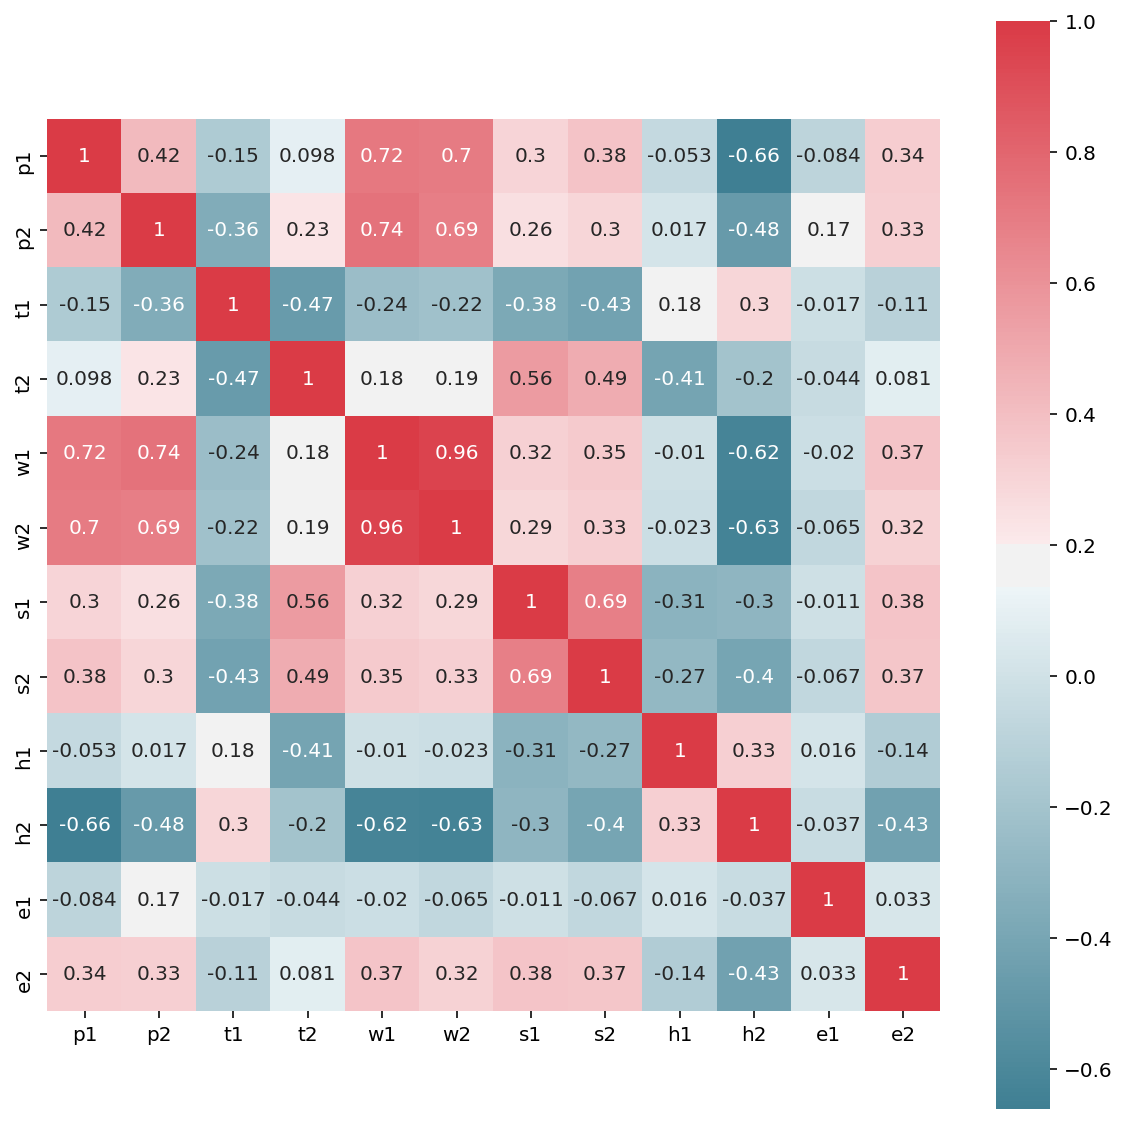

In [77]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(a, mask=np.zeros_like(a, dtype=np.bool), annot=True, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.xticks(np.arange(len(yCol))+0.5, yCol);
plt.yticks(np.arange(len(yCol))+0.5, yCol);
plt.show()

### 8.3 Market Share

In [78]:
swissData = pd.read_csv('../Data/swissData.csv') ## 90 variables + BFS Code that identifies the municipalities
dfFeat = pd.read_csv('../data/featuresList2.csv')  ## Features of the paper
dfFeat = dfFeat.sort_values(by=['BFS']).reset_index(drop=True)
popSwiss = swissData.filter(['pop1', 'BFS'])
popSwiss = popSwiss.sort_values(['pop1'], ascending=False)
mun = gpd.read_file('../data/shapeFiles/municipalities.shp')
#mun = mun.to_crs({'init': 'epsg:2056'})
mun = mun.to_crs({'init': 'epsg:21781'})  #change coordinate system CH1903
mun = mun.sort_values(by='BFS_NUMMER')
mun = mun.reset_index(drop=True)
mun1 = mun.filter(['BFS_NUMMER', 'GEM_FLAECH', 'NAME'])
mun1.columns = ['BFS', 'AREA', 'NAME']
mun1 = pd.merge(popSwiss, mun1, on='BFS')
mun1['popDensity']= mun1.pop1/mun1.AREA
ms = dfFeat.filter(['BFS', 'f6'])
mun1 = pd.merge(mun1,ms, on='BFS')

Text(0.5, 0, 'Market Share (%)')

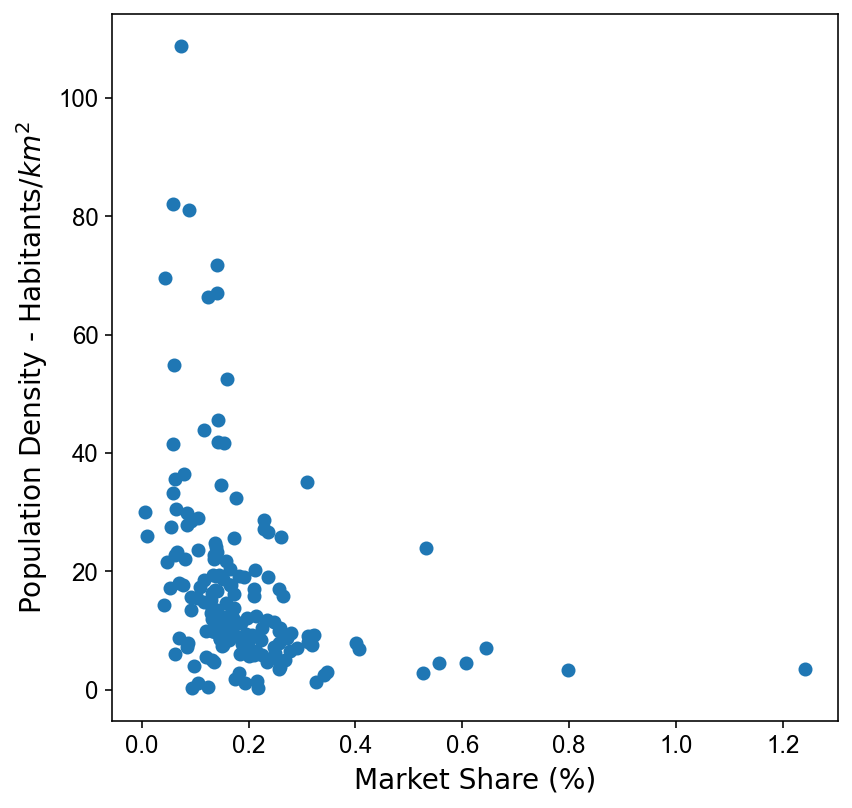

In [79]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
ax = setFont(ax, 'Arial', 12)
plt.scatter(mun1.f6, mun1.popDensity)
ax.set_ylabel('Population Density - '+'Habitants/'r'$km^2$', size=14)
ax.set_xlabel('Market Share (%)', size=14)

## 8.4 Performance over different cities charactheristics
We reporte the performance of our model in comparison different cities' charachterics, such as population, market share and population density. We compare the local R2 of the GWR with the cities' carachterics

### Performance and population

In [80]:
y = dfData['pop1'].values

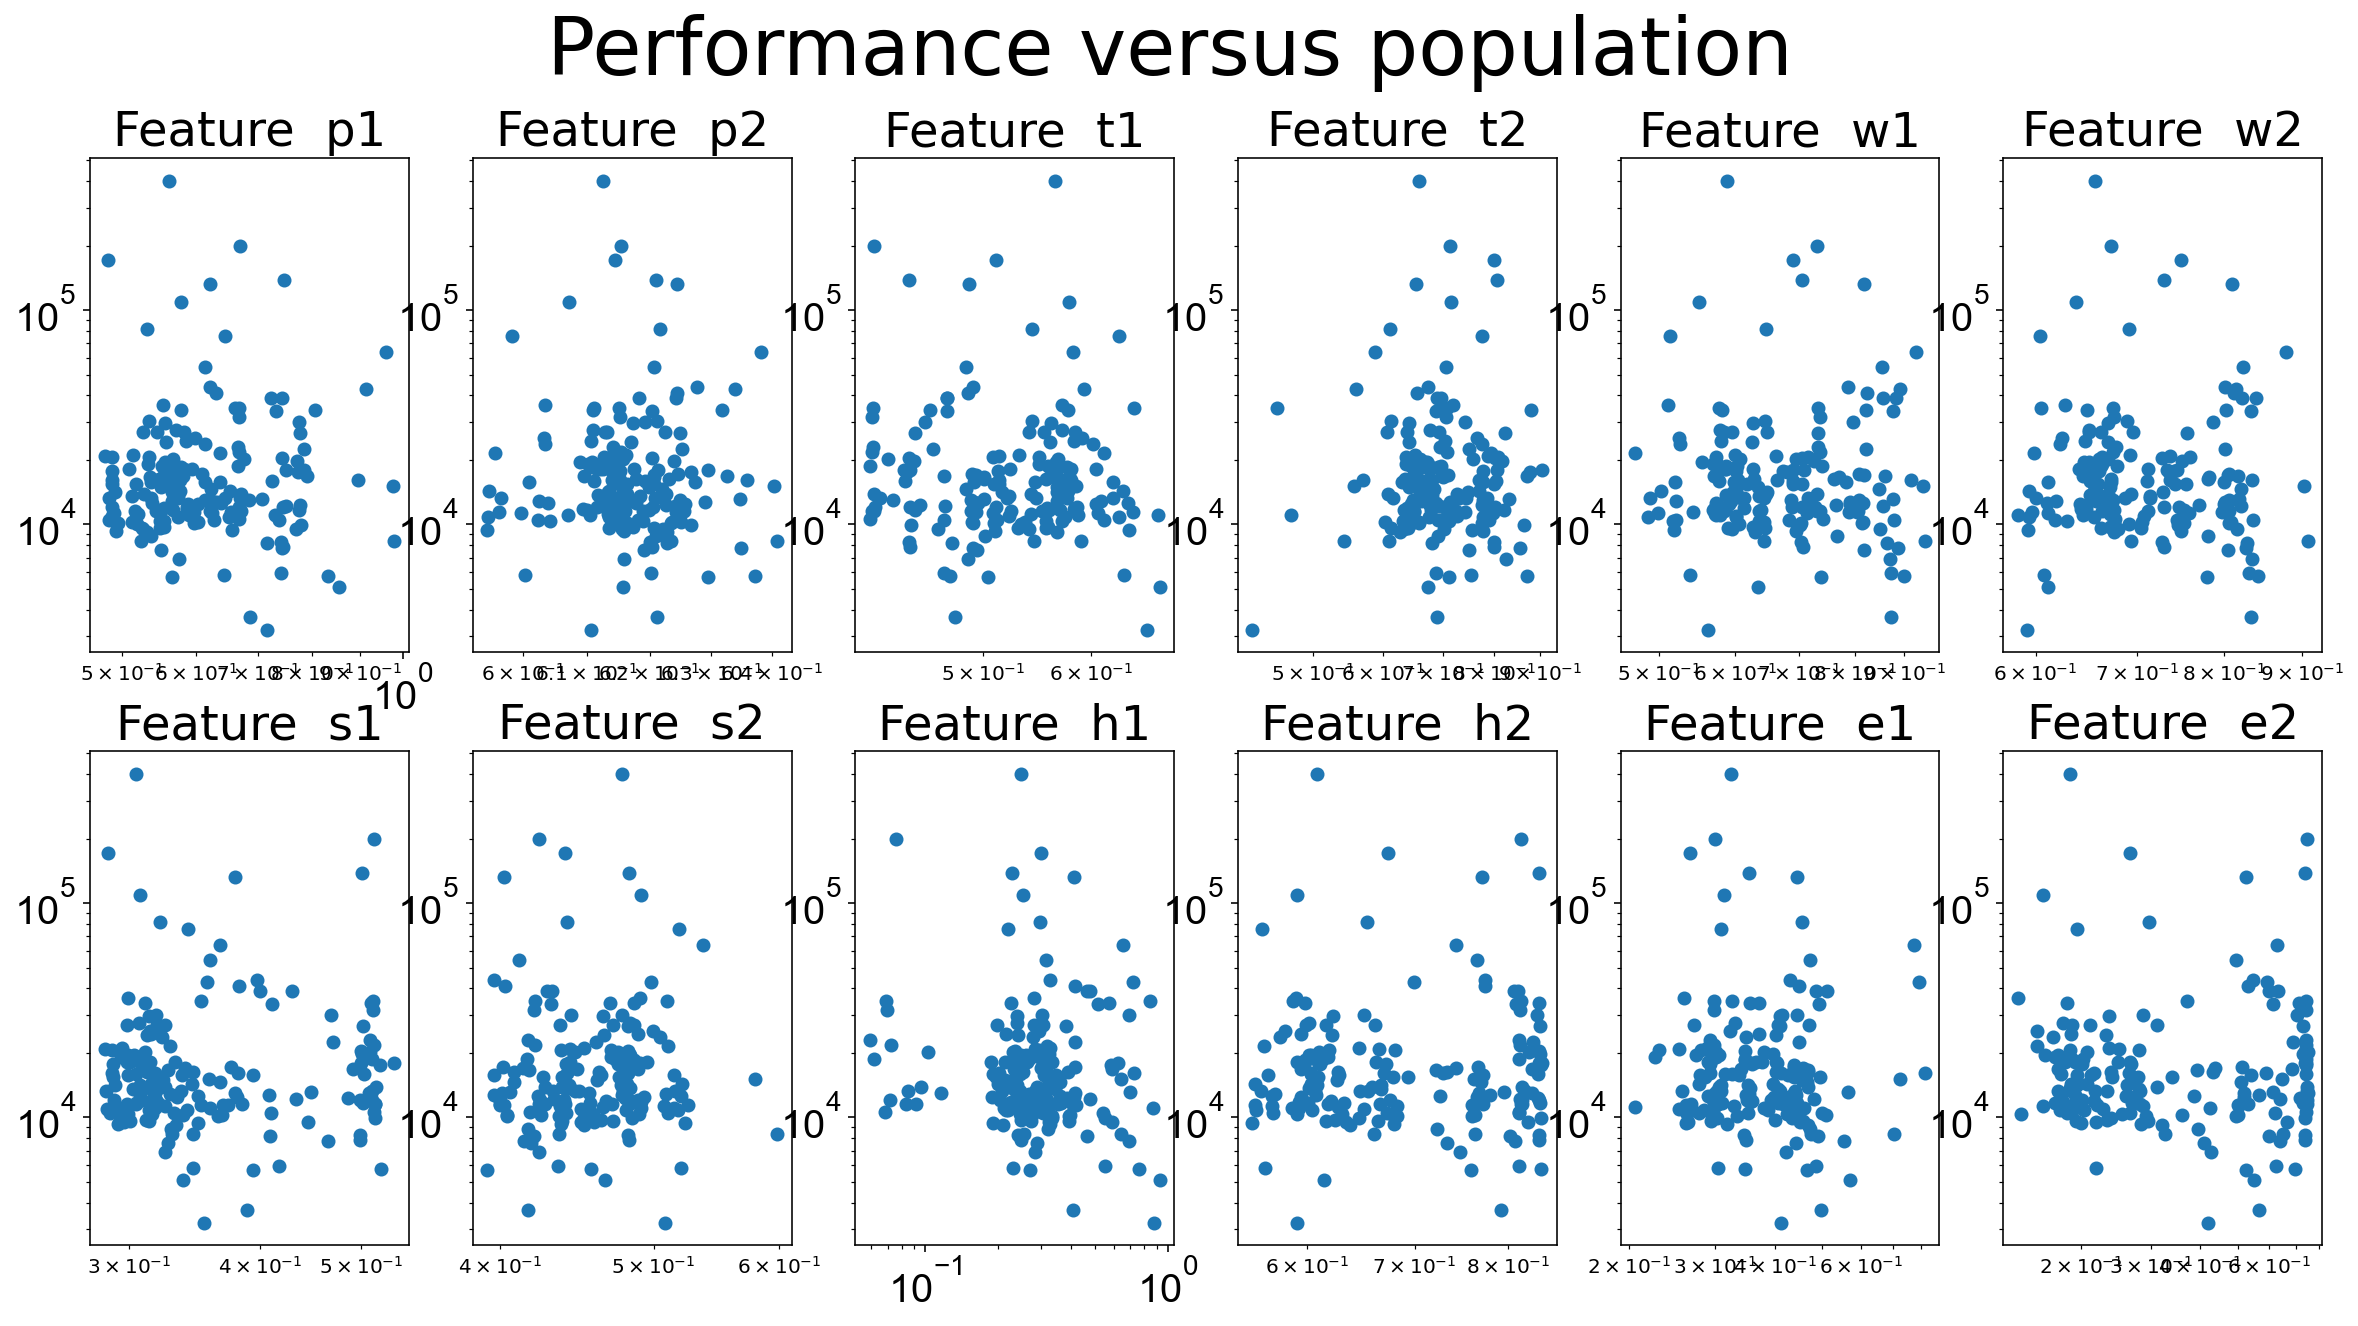

In [81]:
c1 = 0
c2 = 0
f, axs = plt.subplots(2,6,figsize=(20,10))
g_coords = list(dfData.g_coords.values)
for i,target in enumerate(target_variables):
    varnames = feature_selection(dfData,target)
    ##run the different models with the selected variables
    est_gwr = run_GWR(dfData,target,varnames)
    ax = axs[c1][c2]
    ax = setFont(ax, 'Arial', 20)
    ax.scatter(est_gwr.localR2, y)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title('Feature  '+target, size=24)
    c2+=1
    if c2 > 5:
        c2 = 0
        c1 += 1
f.suptitle('Performance versus population', size=40);

In [82]:
#f.savefig('../Response/figures/ppop.pdf',dpi=300,bbox_inches='tight')

### Performance and market share

In [83]:
y = dfData['f6'].values

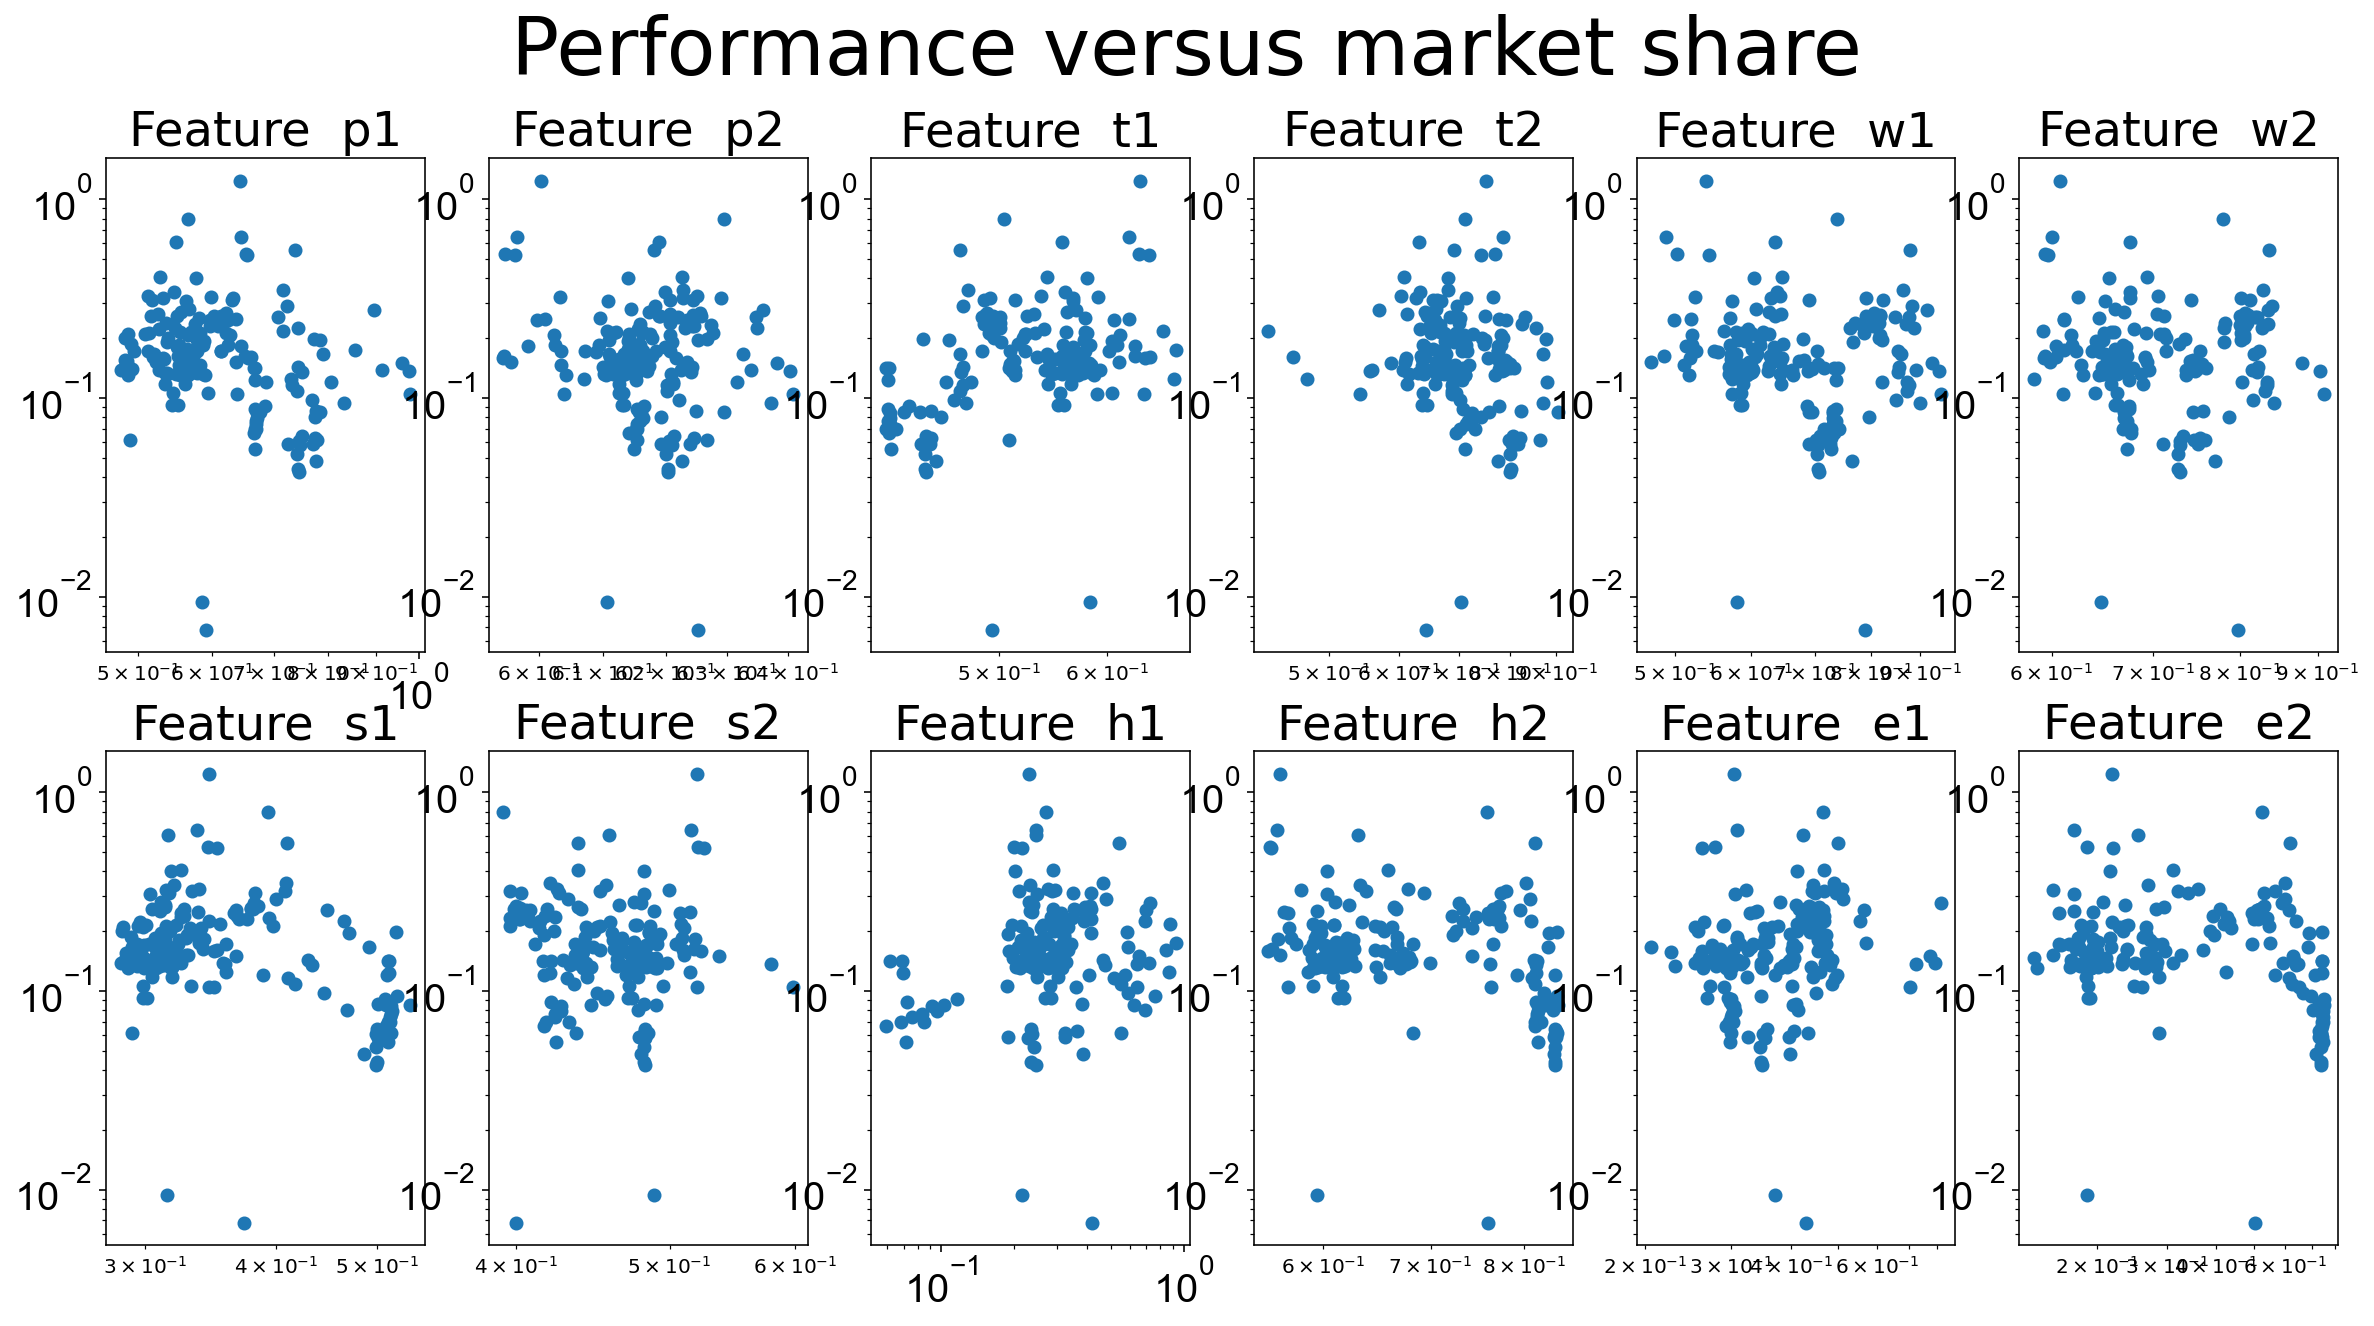

In [84]:
c1 = 0
c2 = 0
f, axs = plt.subplots(2,6,figsize=(20,10))
g_coords = list(dfData.g_coords.values)
for i,target in enumerate(target_variables):
    varnames = feature_selection(dfData,target)
    ##run the different models with the selected variables
    est_gwr = run_GWR(dfData,target,varnames)
    ax = axs[c1][c2]
    ax = setFont(ax, 'Arial', 20)
    ax.scatter(est_gwr.localR2, y)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title('Feature  '+target, size=24)
    c2+=1
    if c2 > 5:
        c2 = 0
        c1 += 1
f.suptitle('Performance versus market share', size=40);

In [85]:
#f.savefig('../Response/figures/pmshare.pdf',dpi=300,bbox_inches='tight')

In [86]:
### Peromance and population density
mun2 = pd.merge(dfData, mun1, on = 'BFS')
mun2 = mun2.drop_duplicates(subset='BFS')
y = mun2.popDensity.values

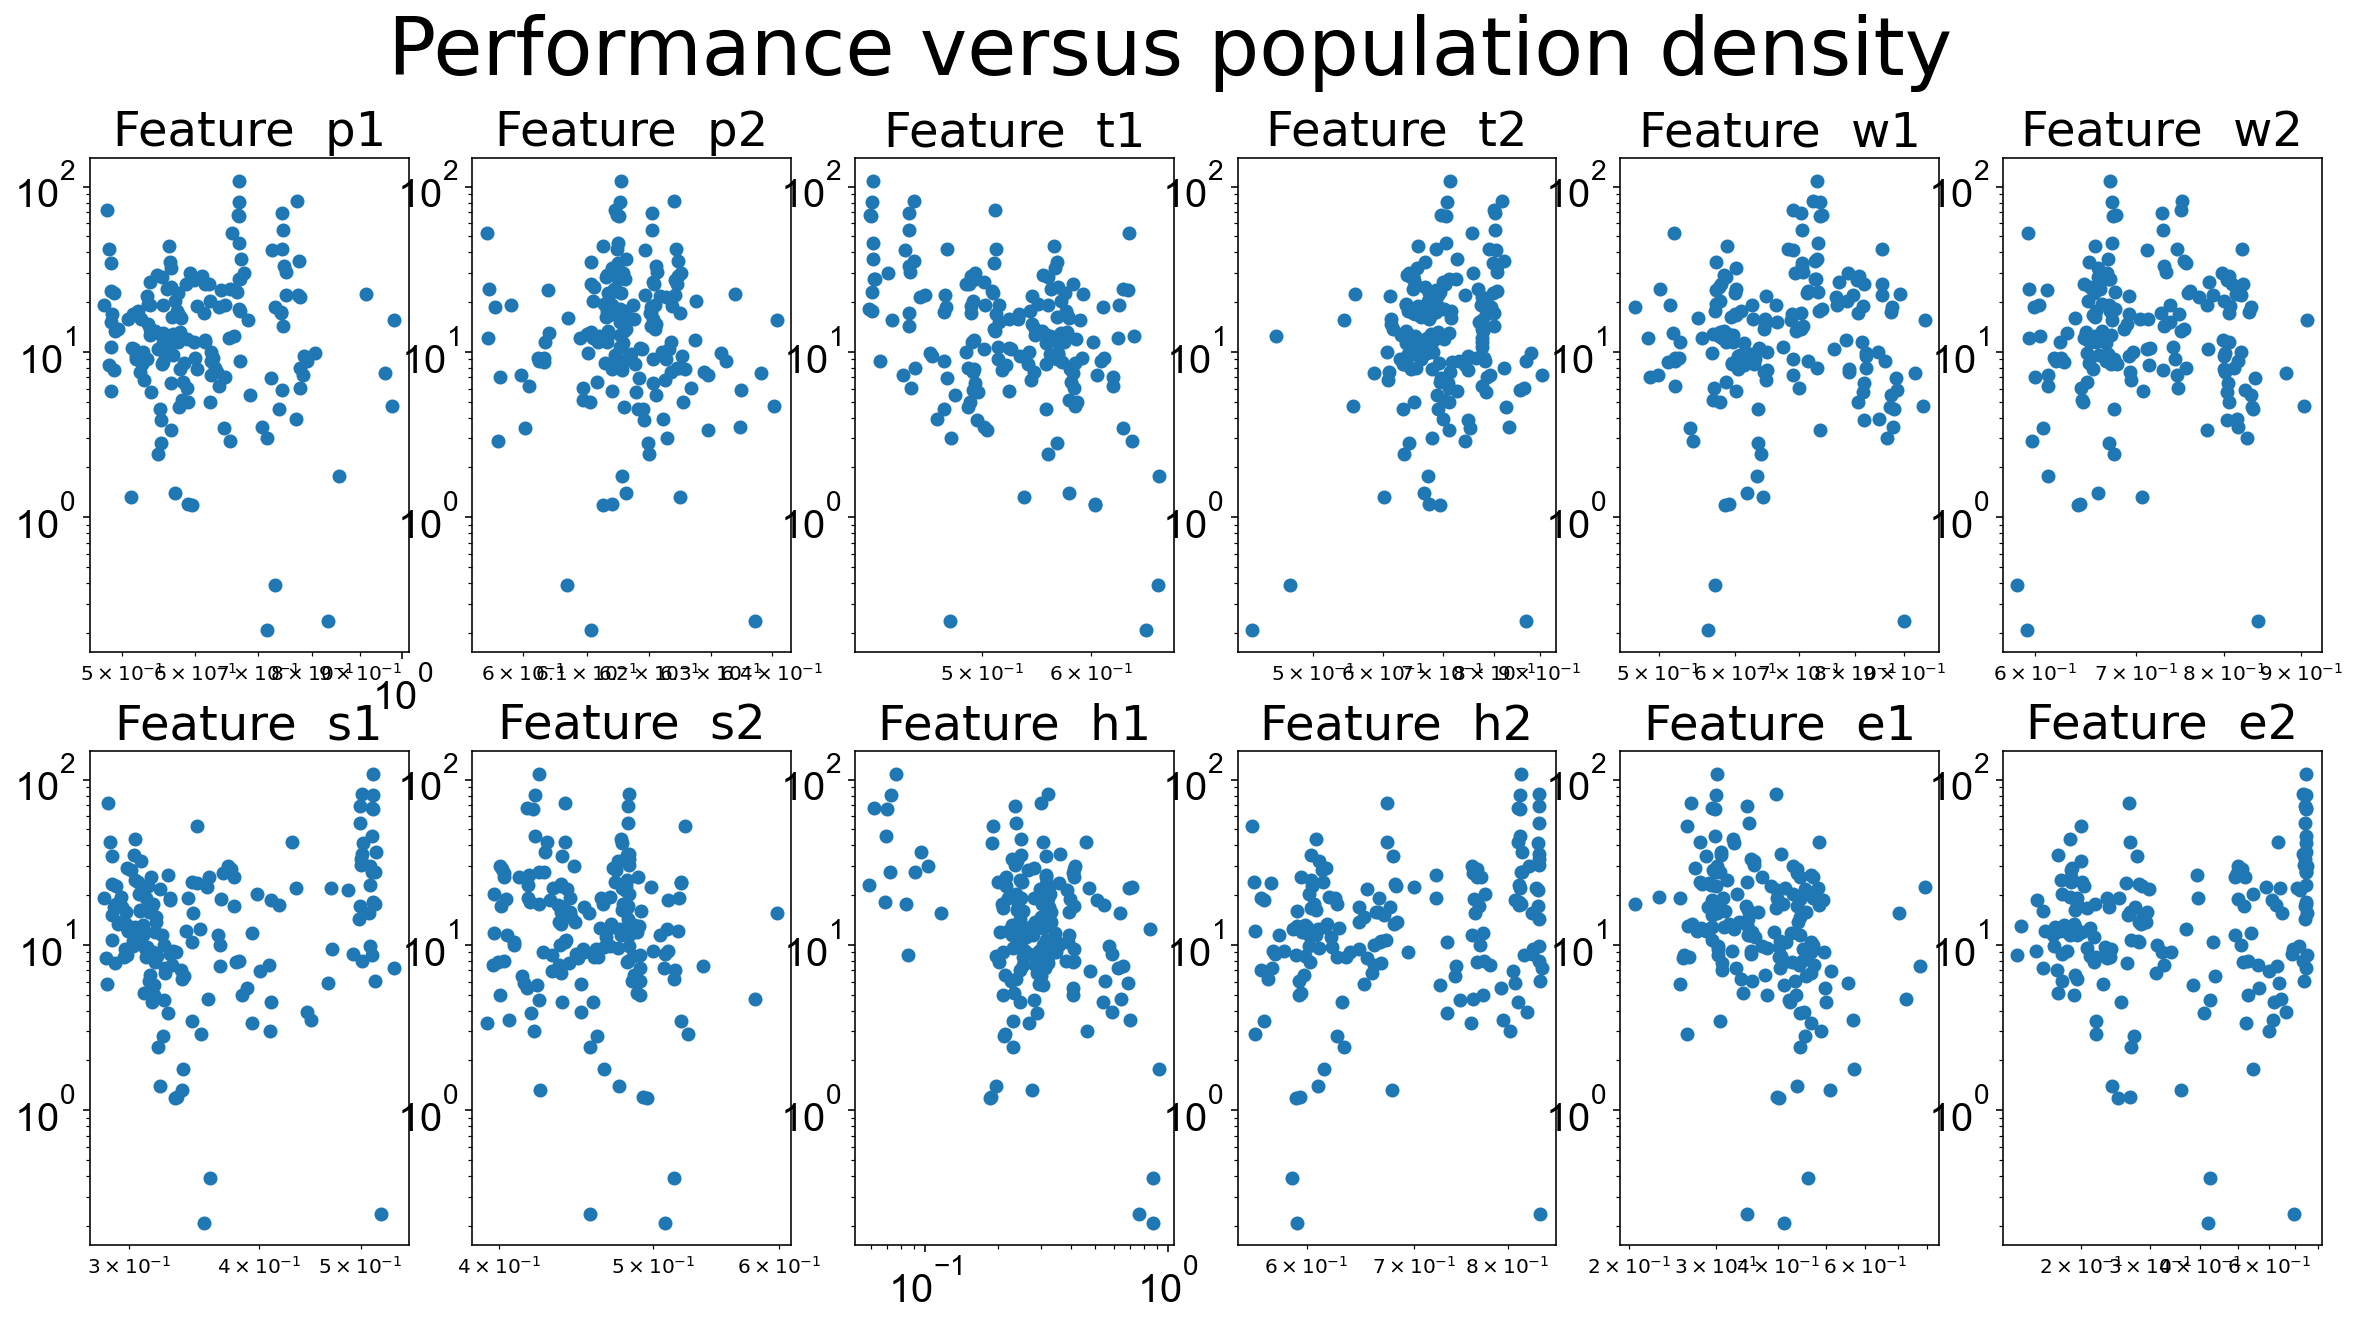

In [87]:
c1 = 0
c2 = 0
f, axs = plt.subplots(2,6,figsize=(20,10))
g_coords = list(dfData.g_coords.values)
for i,target in enumerate(target_variables):
    varnames = feature_selection(dfData,target)
    ##run the different models with the selected variables
    est_gwr = run_GWR(dfData,target,varnames)
    ax = axs[c1][c2]
    ax = setFont(ax, 'Arial', 20)
    ax.scatter(est_gwr.localR2, y)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title('Feature  '+target, size=24)
    c2+=1
    if c2 > 5:
        c2 = 0
        c1 += 1
f.suptitle('Performance versus population density', size=40);

In [ ]:
#f.savefig('../Response/figures/popDens.pdf',dpi=300,bbox_inches='tight')